#### Importación de librerías

In [9]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import importlib
import funciones

import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as tsa


from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
import os
import pickle

os.makedirs('models', exist_ok=True)
importlib.reload(funciones)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format
models = []

#### Metodología de Box-Jenkins
1. 
2. 
3. 
4. 

#### Creamos dataframes

In [2]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main = df_main[df_main["FECHA"] >= "2022-01-01"]
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

<h2>Ejercicio 1</h2>
Buscar 3 (tres) series de tiempo y exponer la problemática de interés analítico (es importante detallar cuáles fueron los motivos de elección y situar al lector en el contexto adecuado).

In [3]:
funciones.display_col3(df_copa.to_frame().tail().to_html(),
             df_recprop.tail().to_frame().to_html(),
             df_regal.tail().to_frame().to_html())

<h2>Ejercicio 2</h2>
Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias.

Exponer los conceptos relacionados con la estacionariedad de la serie.

Gráficos de las series

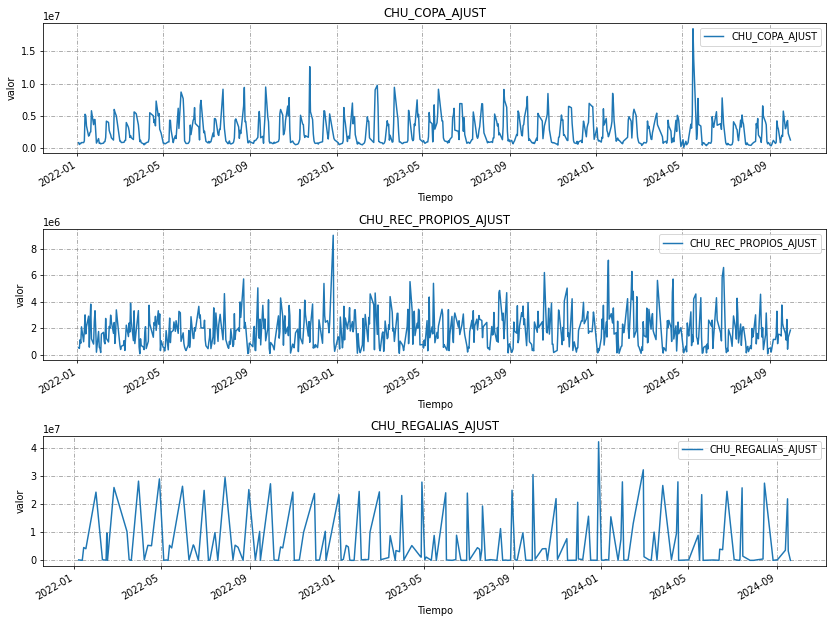

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), dpi=70)  # 3 filas, 1 columna

for i, (df, ax) in enumerate(zip(dataframes, axes)):
    funciones.graficar_serie(serie=df,
             titulo=f"{df.name}",
             xlabel="Tiempo",
             ylabel="valor",
             ax=ax)

plt.tight_layout()  # Evitar superposición
plt.show()

In [5]:
display(HTML("<h2>Boxplot</h2>"))
funciones.graficar_boxplots(dataframes,titulos=titulos)

In [6]:
df = pd.DataFrame(dataframes[2].copy())

df["Year"] = df.index.year
df["Month"] = df.index.month
per = df.groupby(["Year", "Month"]).count()
# period_default  = int(df["Year"].value_counts().mean())
per.mean()

CHU_REGALIAS_AJUST   5.76
dtype: float64

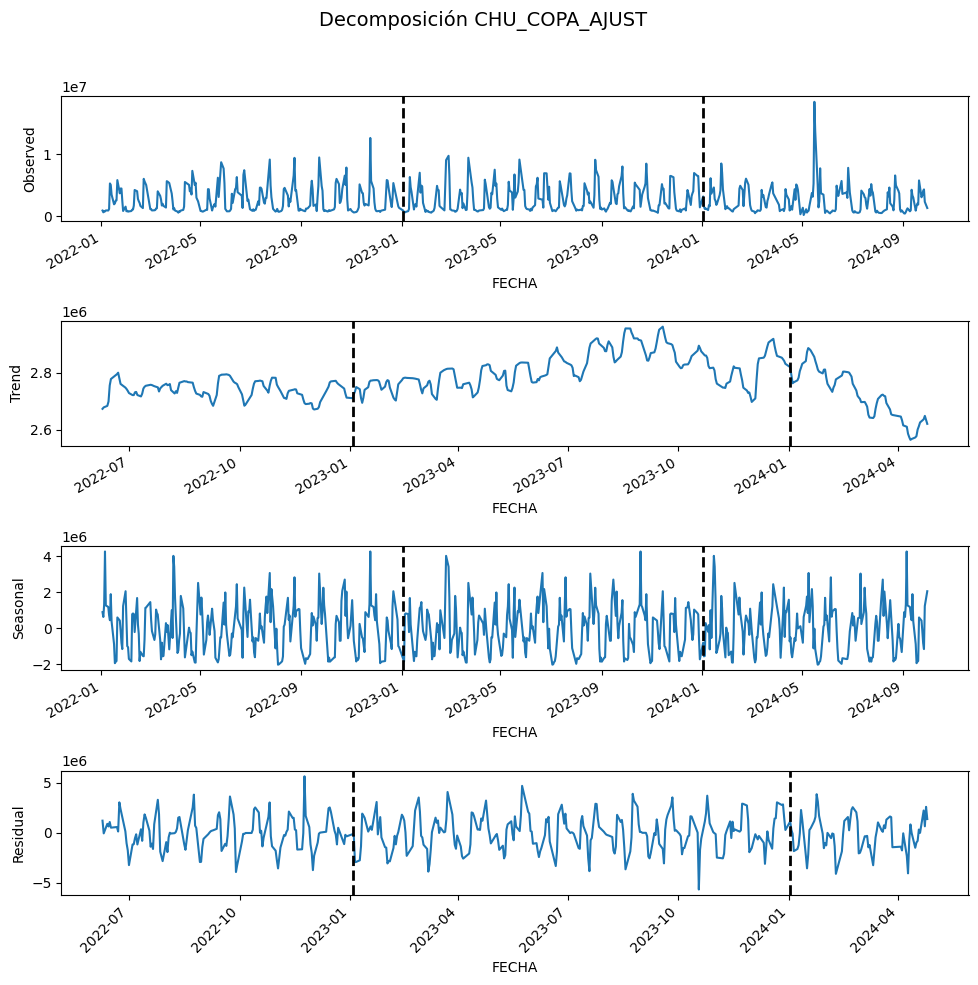

In [31]:
importlib.reload(funciones)
funciones.plot_componentes(dataframes[0], periodos[0], titulos[0])

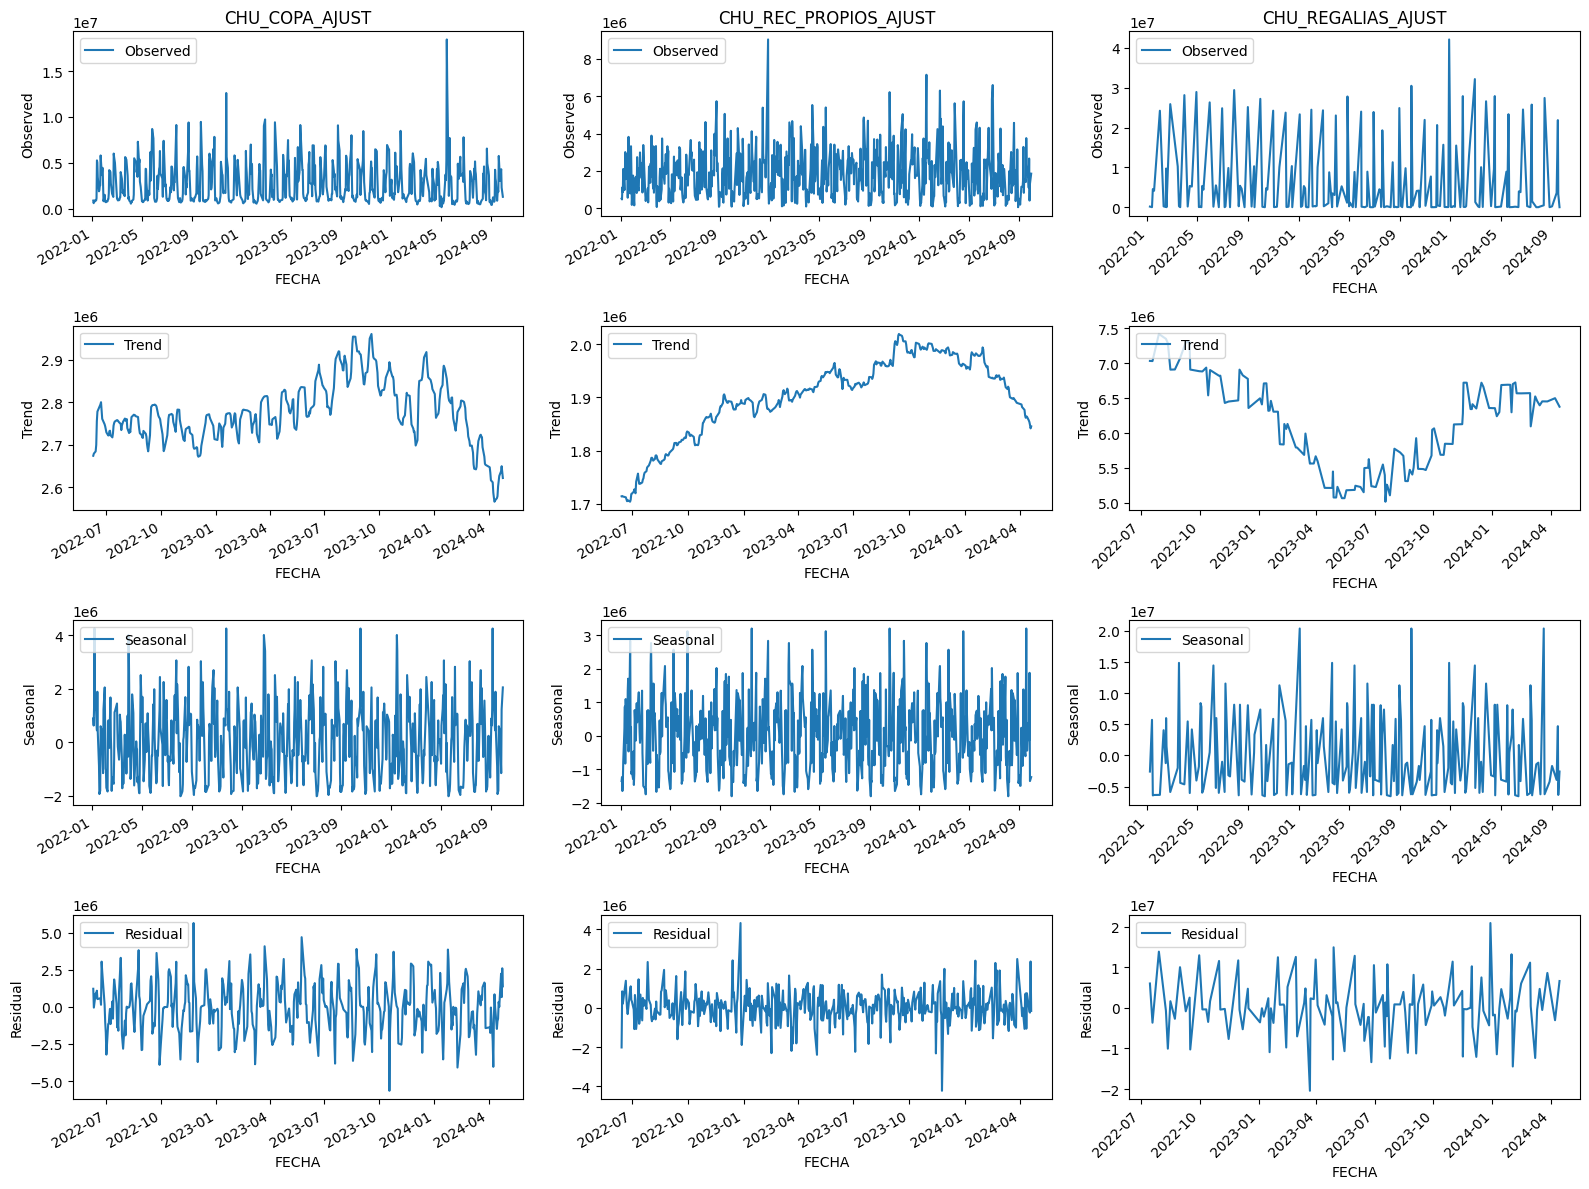

In [26]:
periodos = [211, 218, 63]
display(HTML("<h2>Descomposición de las series</h2>"))
funciones.componentes(dataframes, periodos, titulos)

<h2>Ejercicio 3</h2>
Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?.

Justificar con teoría.

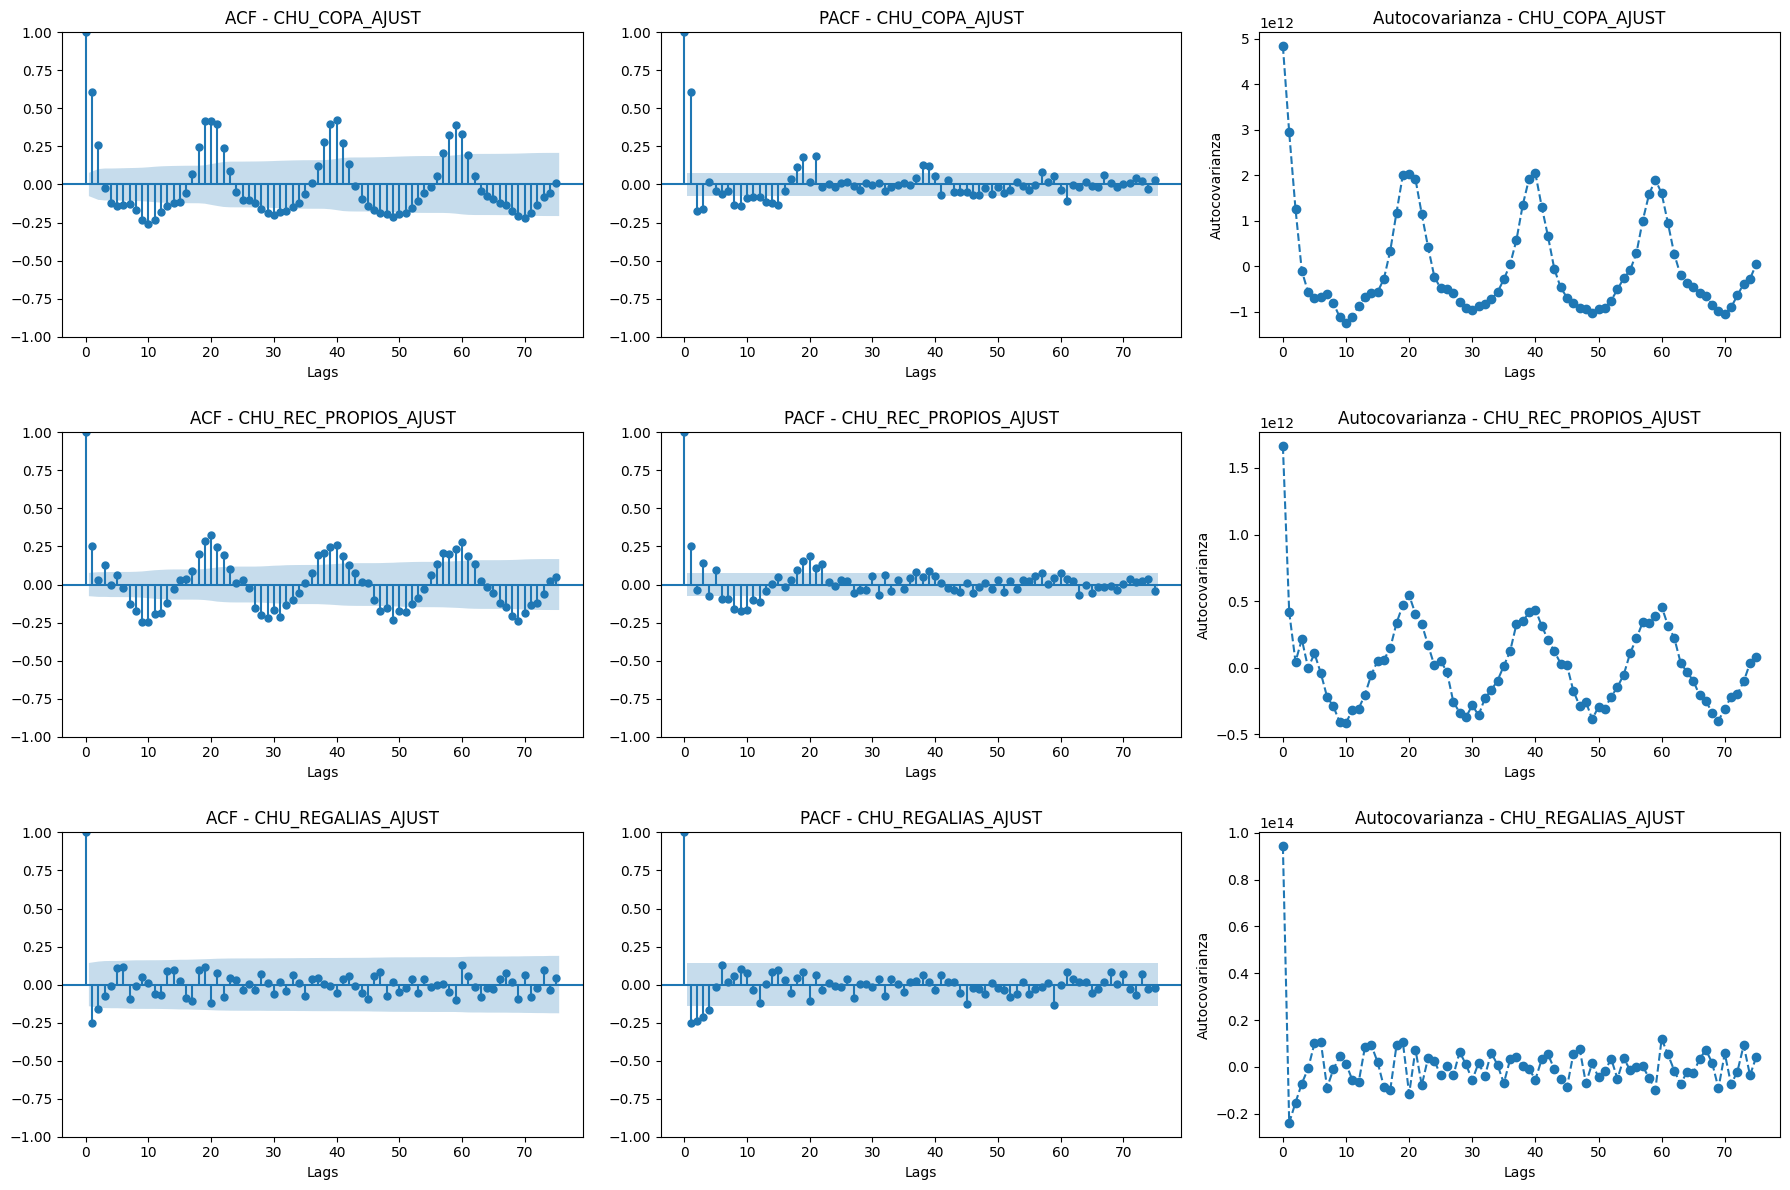

In [8]:
from importlib import reload
funciones.multi_autocov_autocorr(dataframes,75,['a','b','c'])

#### SON ESTACIONARIAS PORQUE:
* FAC es sinusoidal en copa y REC
* Las autocorrelaciones se reducen exponencialmente en REGALIAS


*Vemos que en las tres series no hay estacionalidad porque no vemos picos que se repiten periodicamente. Parecen ser estancionarios, porque su PAC es sinusoidal y su PACF decrece exponencialmente.*

CHU_COPA_AJUST:

1. ACF (Autocorrelación):

* La función de autocorrelación (ACF) nos indica cómo los valores de la serie están correlacionados consigo mismos en diferentes retardos (lags).
* Interpretación: El primer lag muestra una autocorrelación muy alta (cercana a 1), lo cual es común en muchas series temporales, ya que cada punto está altamente correlacionado con el valor inmediato anterior. Luego, vemos una autocorrelación significativa hasta alrededor del lag 10. A partir de ahí, la autocorrelación disminuye y oscila, pero sigue mostrando valores positivos significativos en varios lags posteriores, lo que podría indicar un patrón de periodicidad o una estructura de largo plazo en la serie.
* Análisis: La presencia de autocorrelaciones significativas en varios lags indica que la serie tiene memoria, es decir, que el valor actual está influenciado por valores pasados más allá de los periodos cercanos. Esto sugiere que la serie tiene un componente estructural que necesita modelarse.

2. PACF (Autocorrelación Parcial):

* La función de autocorrelación parcial (PACF) nos ayuda a identificar la dependencia de un punto con sus retardos excluyendo las correlaciones intermedias, es decir, muestra la correlación directa de un punto con su propio retardo, eliminando el efecto de otros retardos.
* Interpretación: En el PACF vemos una caída abrupta después del primer lag, lo que significa que el valor actual está fuertemente influenciado solo por el valor inmediato anterior (lag 1), y las correlaciones en lags más largos se vuelven más débiles, aunque todavía hay algunas correlaciones significativas hasta aproximadamente el lag 20.
* Análisis: La fuerte caída después del lag 1 sugiere que un modelo AR(1) podría ser adecuado para capturar la dependencia en los datos. Sin embargo, las correlaciones parciales en otros lags podrían indicar la necesidad de un modelo con más términos o de incluir una parte de media móvil (MA) en un modelo ARIMA.

3. Autocovarianza:

* La autocovarianza muestra cómo varía la covarianza entre puntos separados por diferentes lags.
* Interpretación: La autocovarianza sigue una forma ondulante, lo que sugiere la presencia de un patrón cíclico o periódico en la serie. Este comportamiento es consistente con lo que observamos en la ACF, donde la correlación no decae de manera rápida.
* Análisis: Este patrón cíclico refuerza la idea de que hay un componente estacional o repetitivo en la serie que podría ser capturado con términos estacionales o de periodicidad en un modelo.

4. ¿Es estacionaria la serie?
A partir de la ACF y PACF, la serie no parece estacionaria, dado que:

* La autocorrelación no decae rápidamente a cero, lo que indica que hay memoria a largo plazo.
* La PACF sugiere que hay correlaciones significativas más allá del primer retardo.

Conclusión: La serie no es estacionaria, y sería recomendable aplicar técnicas como la diferenciación para convertirla en estacionaria antes de modelar. Además, si los picos en la ACF son persistentes y muestran un patrón cíclico, también se debería considerar un componente estacional en el modelo, como un SARIMA o algún ajuste para capturar las periodicidades.

##### CHU_REC_AJUST
1. ACF (Función de Autocorrelación):

* Muestra un patrón cíclico/estacional claro
* Los valores decaen lentamente
* Presenta oscilaciones periódicas significativas
* Esto sugiere que la serie NO es estacionaria
* El patrón cíclico parece tener una periodicidad aproximada de 15-20 lags

2. PACF (Función de Autocorrelación Parcial):

* Muestra correlaciones significativas en los primeros lags
* Después del lag 5-6, las correlaciones son menos significativas
* Se observan algunos picos significativos dispersos

4. Estacionariedad:

* La serie original NO es estacionaria debido a:
    * Patrones cíclicos claros
    * Decaimiento lento en ACF
    * Correlaciones significativas persistentes
* Existe una clara componente estacional en los datos originales

5. Para la serie original, sería necesario:

* Aplicar diferenciación para eliminar tendencia
* Considerar diferenciación estacional
* Posiblemente usar modelos SARIMA

CHU_REGALIAS_AJUST

1. ACF:

* Las correlaciones son mucho más débiles
* No hay un patrón cíclico claro
* La mayoría de los valores están dentro de las bandas de confianza
* Sugiere que la serie se ha vuelto más estacionaria

2. PACF:

* Correlaciones parciales significativas solo en los primeros lags
* Después del lag 5, casi todas las correlaciones están dentro de las bandas de confianza
* Estructura más limpia y menos ruidosa

3. Consideraciones:
* Podría modelarse con un ARIMA más simple
* Los órdenes del modelo podrían ser bajos dado el comportamiento de ACF/PACF
* Posiblemente un ARIMA(p,d,q) donde p y q serían pequeños

## Ejercicio 4
Realizar distintas pruebas de raíces unitarias para determinar si las series elegidas son o no estacionarias.

Componentes deterministicos - Test de Raíces Unitarias - Dickey Fuller

Estos tests se utilizan para determinar si una serie de tiempo es estacionaria o no.

In [9]:
resultados_adf = funciones.test_dickeyfuller(dataframes, titulos)
display(HTML("<h2>Resultados de la prueba de Dickey-Fuller</h2>"))
display(resultados_adf)

Serie                                    CHU_COPA_AJUST  \
ADF (None)                                        -0.73   
p-valor (None)                                     0.40   
Críticos (None)     1%: -2.569, 5%: -1.941, 10%: -1.616   
Rechaza H0 (None)                                 False   
ADF (Drift)                                       -4.86   
p-valor (Drift)                                    0.00   
Críticos (Drift)    1%: -3.441, 5%: -2.866, 10%: -2.569   
Rechaza H0 (Drift)                                 True   
ADF (Trend)                                       -4.90   
p-valor (Trend)                                    0.00   
Críticos (Trend)    1%: -3.973, 5%: -3.417, 10%: -3.131   
Rechaza H0 (Trend)                                 True   

Serie                             CHU_REC_PROPIOS_AJUST  \
ADF (None)                                        -0.60   
p-valor (None)                                     0.46   
Críticos (None)     1%: -2.569, 5%: -1.941, 10%: -1.616   
Rechaza H0 (None)                                 False   
ADF (Drift)                                       -3.92   
p-valor (Drift)                                    0.00   
Críticos (Drift)    1%: -3.441, 5%: -2.866, 10%: -2.569   
Rechaza H0 (Drift)                                 True   
ADF (Trend)                                       -3.94   
p-valor (Trend)                                    0.01   
Críticos (Trend)    1%: -3.973, 5%: -3.417, 10%: -3.131   
Rechaza H0 (Trend)                                False   

Serie                                CHU_REGALIAS_AJUST  
ADF (None)                                        -0.84  
p-valor (None)                                     0.35  
Críticos (None)     1%: -2.579, 5%: -1.943, 10%: -1.615  
Rechaza H0 (None)                                 False  
ADF (Drift)                                      -10.69  
p-valor (Drift)                                    0.00  
Críticos (Drift)    1%: -3.466, 5%: -2.877, 10%: -2.575  
Rechaza H0 (Drift)                                 True  
ADF (Trend)                                      -10.84  
p-valor (Trend)                                    0.00  
Críticos (Trend)    1%: -4.008, 5%: -3.434, 10%: -3.141  
Rechaza H0 (Trend)                                 True

<b>Análisis de CHU_COPA_AJUST</b>

Test ADF sin drift ni tendencia:
* Estadístico ADF: -0.641313
* p-valor: 0.437307
* Interpretación: En este caso, el p-valor (0.437307) es mayor que los niveles de significancia comunes (0.01, 0.05, 0.1). Además, el estadístico ADF (-0.641313) es mayor que todos los valores críticos. Esto sugiere que no podemos rechazar la hipótesis nula de no estacionariedad. Es decir, según este test, la serie parece no ser estacionaria.

Test ADF con drift (constante):
* Estadístico ADF: -5.671137
* p-valor: 0.000001
* Interpretación: El p-valor es muy pequeño (0.000001 < 0.01) y el estadístico ADF (-5.671137) es menor que todos los valores críticos. Esto nos permite rechazar la hipótesis nula con un alto nivel de confianza. Según este test, la serie parece ser estacionaria alrededor de una constante.

Test ADF con tendencia:
* Estadístico ADF: -6.436652
* p-valor: 0.000000
* Interpretación: Al igual que en el caso anterior, el p-valor es extremadamente pequeño y el estadístico ADF es menor que todos los valores críticos. Podemos rechazar la hipótesis nula con un alto nivel de confianza. Este test sugiere que la serie es estacionaria alrededor de una tendencia.

Conclusión general:
Los resultados de estos tres tests muestran una imagen interesante:
* Sin considerar drift ni tendencia, la serie parece no estacionaria.
* Al considerar un término constante (drift), la serie muestra evidencia de estacionariedad.
* Al considerar tanto drift como tendencia, la serie muestra una fuerte evidencia de estacionariedad.

Esto sugiere que tu serie temporal probablemente tiene una tendencia y/o un nivel medio distinto de cero. La serie parece ser estacionaria una vez que se tienen en cuenta estos componentes.

Recomendaciones:
* Visualiza tu serie temporal para confirmar visualmente la presencia de una tendencia o un nivel medio distinto de cero.
* Considera diferenciar la serie si planeas usar modelos que requieran estacionariedad estricta.
* Si estás modelando la serie, podrías incluir términos de tendencia y/o constantes en tu modelo para capturar estos componentes.
* Ten en cuenta que la elección entre los modelos con drift y con tendencia dependerá de tu conocimiento del proceso que genera los datos y del comportamiento observado en la serie.

In [11]:
importlib.reload(funciones)
display(HTML("<h2>Resultados de la prueba de Augmented Dickey-Fuller</h2>"))
display(funciones.Augmented_Dickey_Fuller_Test_func2(dataframes))

Test Statistic p-value No Lags No Obs  \
CHU_COPA_AJUST                 -4.86    0.00      20    633   
CHU_REC_PROPIOS_AJUST          -3.92    0.00      20    635   
CHU_REGALIAS_AJUST            -10.69    0.00       3    186   

                           Crit Val (1%,5%,10%) Estacionaria 5%  
CHU_COPA_AJUST         [-3.441, -2.866, -2.569]            True  
CHU_REC_PROPIOS_AJUST  [-3.441, -2.866, -2.569]            True  
CHU_REGALIAS_AJUST     [-3.466, -2.877, -2.575]            True

A continuacion, analizamos mediante diferentes pruebas el orden de diferenciacion requerido para que la serie pueda llegar a ser estacionaria. Este es un analizis complementario, junto con los otros realizados. 
Las pruebas realizadas son:

* Prueba de Dickey-Fuller aumentada 
* Prueba de Kwiatkowski-Phillips-Schmidt-Shin
* Prueba de Phillips-Perron

In [12]:

display(funciones.estacionario2(dataframes))

ADF KPSS PP Should Diff ADFtest
CHU_COPA_AJUST          0    0  0       (0.01, False)
CHU_REC_PROPIOS_AJUST   0    0  0       (0.01, False)
CHU_REGALIAS_AJUST      0    0  0       (0.01, False)

*Según el test de KPSS debemos diferenciar 1 vez para que las series sean estacionarias*

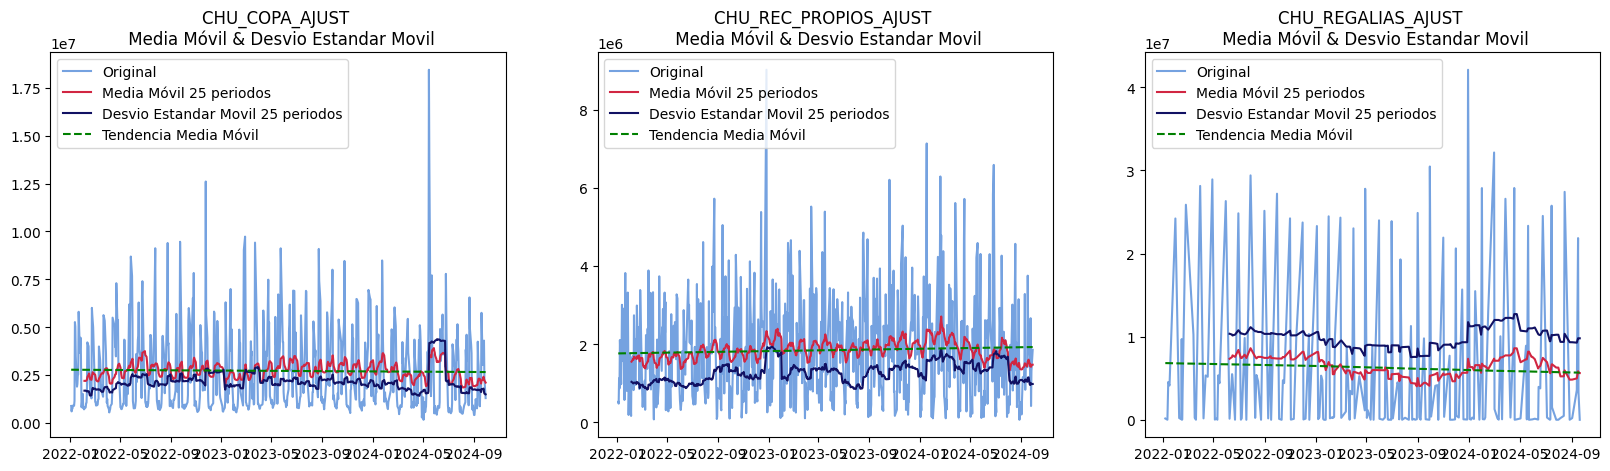

In [13]:

funciones.test_stationarity(dataframes)

#### PREGUNTA: EN BASE A LOS GRAFICOS DE ARRIBA........ ¿HACE FALTA APLICAR BOX-COX? PARA ESTABILIZAR LA VARIANZA....

1. Gráfico de la izquierda (CHU_COPA_AJUST):
* Descripción: Se observa la serie original (en azul claro), junto con una media móvil de 25 períodos (línea roja), un desvío estándar móvil de 25 períodos (línea azul oscuro) y una tendencia (línea verde punteada).
* Interpretación: La serie original muestra un comportamiento muy fluctuante, con picos pronunciados. Sin embargo, la media móvil y el desvío estándar parecen estabilizarse, sugiriendo cierta suavización en los valores. No obstante, la varianza no parece ser constante a lo largo del tiempo, dado que los picos y caídas en la serie son bastante marcados.
* Estacionariedad: Es poco probable que esta serie sea estacionaria, ya que muestra grandes variaciones en la magnitud (especialmente en los picos). Esto sugiere que la serie podría beneficiarse de transformaciones adicionales para estabilizar la varianza.

2. Gráfico del centro (CHU_REC_PROPIOS_AJUST):
* Descripción: Similar al primer gráfico, muestra la serie original, la media móvil, el desvío estándar móvil y la tendencia.
* Interpretación: La serie también presenta fluctuaciones importantes, aunque los picos no son tan extremos como en la serie anterior. La media móvil parece mantenerse relativamente constante a lo largo del tiempo, pero la varianza sigue mostrando incrementos y disminuciones notables.
* Estacionariedad: Tampoco parece ser estacionaria, ya que los valores de la serie original varían significativamente en diferentes períodos. Aunque la media móvil es estable, el desvío estándar refleja variaciones en la dispersión de los datos.

3. Gráfico de la derecha (CHU_REGALIAS_AJUST):
* Descripción: Igual que los gráficos anteriores, muestra la serie original junto con la media móvil, desvío estándar móvil y tendencia.
* Interpretación: Esta serie tiene fluctuaciones marcadas, con algunos picos importantes. La media móvil muestra una leve tendencia ascendente, mientras que el desvío estándar también varía, indicando que la dispersión de los datos no es constante.
* Estacionariedad: Al igual que en los casos anteriores, la serie no parece estacionaria debido a la variabilidad en la magnitud de los datos.


¿Es necesaria la transformación de Box-Cox?
La transformación de Box-Cox puede ser útil para estabilizar la varianza en series temporales con fluctuaciones grandes. En estos gráficos, la varianza no parece ser constante (heterocedasticidad), ya que los picos varían mucho en diferentes puntos del tiempo. Aplicar una transformación como Box-Cox podría ayudar a hacer la varianza más estable y, potencialmente, facilitar el análisis de las series, especialmente si planeas modelarlas con métodos que requieren estacionariedad.

Resumen:
* Ninguna de las series parece ser estacionaria.
* La transformación de Box-Cox podría ser recomendable para estabilizar la varianza y hacer que las series sean más apropiadas para el modelado.

<h3>Auto Arima</h3>

In [32]:
models = []

In [33]:
def save_model(datos = {"titulo":None}):
    if datos["titulo"]:
      titulo = datos["titulo"]
      with open(f"models/{titulo}.pkl", "wb") as archivo:
        pickle.dump(datos["modelo"], archivo)
      if titulo in [m["titulo"] for m in models]:
          for m in models:
              if m["titulo"] == titulo:
                  m = {}
                  for dato in datos:
                      m[dato] = datos[dato]
                  break
                
      else:
          models.append(datos)

In [34]:
for i, df_train in enumerate(dataframes):
    # Entrenamiento del modelo ARIMA
    model = auto_arima(df_train, trace=False, suppress_warnings=True, )
    titulo = f"aa_df{i}"
    save_model({
    "modelo": model,
    "dataset": f"{df_train.name} complete",
    "titulo": f"aa_df{i}",
    "aic": model.aic(),
    "order": model.order})
    with open(f"models/{titulo}.pkl", "wb") as archivo:
        pickle.dump(model, archivo)
display(HTML("<h2>Modelos ARIMA</h2>"))
display(pd.DataFrame(models))

modelo                         dataset  titulo  \
0   ARIMA(3,0,0)(0,0,0)[0] intercept         CHU_COPA_AJUST complete  aa_df0   
1   ARIMA(2,0,2)(0,0,0)[0] intercept  CHU_REC_PROPIOS_AJUST complete  aa_df1   
2   ARIMA(4,0,0)(0,0,0)[0] intercept     CHU_REGALIAS_AJUST complete  aa_df2   

        aic      order  
0 20,626.54  (3, 0, 0)  
1 20,267.19  (2, 0, 2)  
2  6,626.04  (4, 0, 0)

<h3>Modelos ARMA</h3>

In [35]:
import itertools
import statsmodels.api as sm
def modelo_arma(df):
    p_values = range(0, 8)
    q_values = range(0, 8)
    resultados = []
    mejor_aic = float("inf")
    mejor_order = None
    mejor_modelo = None


    for p, q in itertools.product(p_values, q_values):
        try:
            modelo = sm.tsa.arima.ARIMA(df, order=(p, 0, q))
            resultado = modelo.fit()
            aic = resultado.aic
            resultados.append((p, q, aic))

            if aic < mejor_aic:
                mejor_aic = aic
                mejor_order = (p, q)
                mejor_modelo = resultado

        except Exception as e:
            print(f"Error en el modelo ARMA({p},{q}): {e}")

    # print(f"Mejor modelo ARMA: order={mejor_order} con AIC={mejor_aic}")
    # for p, q, aic in resultados:
    #     print(f"ARMA({p},{q}) AIC: {aic}")
    return mejor_modelo

for i, df_train in enumerate(dataframes):
    # Entrenamiento del modelo ARMA
    resultados = []
    mejor_aic = float("inf")
    mejor_order = None
    mejor_modelo = None
    model = modelo_arma(df_train)
    titulo = f"arma_df{i}"
    save_model({
        "modelo": model,
        "dataset": f"{df_train.name} complete",
        "titulo": titulo,
        "aic": model.aic,
        "order": model.model.order})
    with open(f"models/{titulo}.pkl", "wb") as archivo:
        pickle.dump(model, archivo)
display(HTML("<h2>Modelos ARIMA y ARMA</h2>"))
display(pd.DataFrame(models))

modelo  \
0                   ARIMA(3,0,0)(0,0,0)[0] intercept   
1                   ARIMA(2,0,2)(0,0,0)[0] intercept   
2                   ARIMA(4,0,0)(0,0,0)[0] intercept   
3  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
5  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   

                          dataset    titulo       aic      order  
0         CHU_COPA_AJUST complete    aa_df0 20,626.54  (3, 0, 0)  
1  CHU_REC_PROPIOS_AJUST complete    aa_df1 20,267.19  (2, 0, 2)  
2     CHU_REGALIAS_AJUST complete    aa_df2  6,626.04  (4, 0, 0)  
3         CHU_COPA_AJUST complete  arma_df0 20,548.29  (7, 0, 4)  
4  CHU_REC_PROPIOS_AJUST complete  arma_df1 20,141.55  (2, 0, 7)  
5     CHU_REGALIAS_AJUST complete  arma_df2  6,622.50  (2, 0, 2)

<h3> Métricas para modelos de autoarima automatico y manual </h3>

<h4>CHU_COPA_AJUST</h4>

Modelo 1: AUTOARIMA - ARIMA(3,0,0)(0,0,0)[0] intercept

In [36]:
modelo_aa_ARIMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(3,0,0))
resultado_aa_ARIMA_copa = modelo_aa_ARIMA_copa.fit()
resultado_aa_ARIMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                  654
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -10308.267
Date:                Fri, 01 Nov 2024   AIC                          20626.534
Time:                        19:07:51   BIC                          20648.950
Sample:                             0   HQIC                         20635.226
                                - 654                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.705e+06   1.33e+05     20.343      0.000    2.44e+06    2.97e+06
ar.L1          0.6868      0.036     18.922      0.000       0.616       0.758
ar.L2         -0.0594      0.043     -1.379      0.168      -0.144       0.025
ar.L3         -0.1630      0.043     -3.794      0.000      -0.247      -0.079
sigma2      2.877e+12      0.148   1.94e+13      0.000    2.88e+12    2.88e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2888.61
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             2.14
Prob(H) (two-sided):                  0.52   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+38. Standard errors may be unstable.
"""

Modelo 2 ARMA(6,3)

In [37]:
modelo_ARMA_copa = sm.tsa.arima.ARIMA(dataframes[0], order=(6,0,3))
modelo_ARMA_copa = modelo_ARMA_copa.fit()
modelo_ARMA_copa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         CHU_COPA_AJUST   No. Observations:                  654
Model:                 ARIMA(6, 0, 3)   Log Likelihood              -10263.825
Date:                Fri, 01 Nov 2024   AIC                          20549.649
Time:                        19:07:53   BIC                          20598.963
Sample:                             0   HQIC                         20568.772
                                - 654                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.705e+06   2.17e-08   1.25e+14      0.000    2.71e+06    2.71e+06
ar.L1          1.4323      0.084     16.980      0.000       1.267       1.598
ar.L2          0.3206      0.186      1.722      0.085      -0.044       0.686
ar.L3         -1.6232      0.160    -10.160      0.000      -1.936      -1.310
ar.L4          0.8143      0.075     10.861      0.000       0.667       0.961
ar.L5          0.1400      0.074      1.882      0.060      -0.006       0.286
ar.L6         -0.2455      0.047     -5.279      0.000      -0.337      -0.154
ma.L1         -0.8734      0.073    -11.999      0.000      -1.016      -0.731
ma.L2         -0.8810      0.130     -6.758      0.000      -1.137      -0.625
ma.L3          0.9597      0.069     13.981      0.000       0.825       1.094
sigma2       2.76e+12   1.25e-13   2.22e+25      0.000    2.76e+12    2.76e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              4711.33
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             2.22
Prob(H) (two-sided):                  0.26   Kurtosis:                        15.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.77e+40. Standard errors may be unstable.
"""

<h4>CHU_REC_PROPIOS_AJUST</h4>

In [38]:
modelo_aa_ARIMA_RP= sm.tsa.arima.ARIMA(dataframes[1], order=(2,0,2))
modelo_aa_ARIMA_RP = modelo_aa_ARIMA_RP.fit()
modelo_aa_ARIMA_RP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CHU_REC_PROPIOS_AJUST   No. Observations:                  656
Model:                    ARIMA(2, 0, 2)   Log Likelihood              -10127.561
Date:                   Fri, 01 Nov 2024   AIC                          20267.121
Time:                           19:07:53   BIC                          20294.038
Sample:                                0   HQIC                         20277.557
                                   - 656                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.833e+06   7.14e+04     25.685      0.000    1.69e+06    1.97e+06
ar.L1         -0.0354      0.339     -0.104      0.917      -0.700       0.629
ar.L2          0.3643      0.140      2.610      0.009       0.091       0.638
ma.L1          0.3374      0.345      0.977      0.329      -0.339       1.014
ma.L2         -0.3769      0.230     -1.641      0.101      -0.827       0.073
sigma2      1.502e+12      0.040   3.76e+13      0.000     1.5e+12     1.5e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               187.41
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+28. Standard errors may be unstable.
"""

In [39]:
modelo_ARMA_RP = sm.tsa.arima.ARIMA(dataframes[1], order=(2,0,7))
modelo_ARMA_RP = modelo_ARMA_RP.fit()
modelo_ARMA_RP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     CHU_REC_PROPIOS_AJUST   No. Observations:                  656
Model:                    ARIMA(2, 0, 7)   Log Likelihood              -10059.773
Date:                   Fri, 01 Nov 2024   AIC                          20141.547
Time:                           19:07:55   BIC                          20190.894
Sample:                                0   HQIC                         20160.679
                                   - 656                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.833e+06   5.28e-08   3.47e+13      0.000    1.83e+06    1.83e+06
ar.L1          1.8986      0.002   1121.011      0.000       1.895       1.902
ar.L2         -0.9990      0.002   -604.133      0.000      -1.002      -0.996
ma.L1         -1.8194      0.041    -44.767      0.000      -1.899      -1.740
ma.L2          0.6269      0.081      7.736      0.000       0.468       0.786
ma.L3          0.5255      0.090      5.870      0.000       0.350       0.701
ma.L4         -0.3307      0.100     -3.308      0.001      -0.527      -0.135
ma.L5          0.2309      0.098      2.351      0.019       0.038       0.424
ma.L6         -0.2382      0.095     -2.515      0.012      -0.424      -0.053
ma.L7          0.0899      0.045      1.991      0.046       0.001       0.178
sigma2      1.363e+12   4.07e-14   3.35e+25      0.000    1.36e+12    1.36e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               297.27
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+41. Standard errors may be unstable.
"""

<h4>CHU_REGALIAS_AJUST</h4>

In [40]:
modelo_aa_ARIMA_REG= sm.tsa.arima.ARIMA(dataframes[2], order=(4,0,0))
modelo_aa_ARIMA_REG = modelo_aa_ARIMA_REG.fit()
modelo_aa_ARIMA_REG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     CHU_REGALIAS_AJUST   No. Observations:                  190
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -3307.020
Date:                Fri, 01 Nov 2024   AIC                           6626.040
Time:                        19:07:56   BIC                           6645.522
Sample:                             0   HQIC                          6633.932
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.313e+06   4.05e+05     15.607      0.000    5.52e+06    7.11e+06
ar.L1         -0.4067      0.120     -3.387      0.001      -0.642      -0.171
ar.L2         -0.3655      0.136     -2.694      0.007      -0.631      -0.100
ar.L3         -0.2793      0.088     -3.165      0.002      -0.452      -0.106
ar.L4         -0.1689      0.064     -2.632      0.008      -0.295      -0.043
sigma2      7.751e+13      0.014   5.53e+15      0.000    7.75e+13    7.75e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.40
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             1.12
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+30. Standard errors may be unstable.
"""

In [41]:
modelo_ARMA_REG = sm.tsa.arima.ARIMA(dataframes[2], order=(2,0,2))
modelo_ARMA_REG = modelo_ARMA_REG.fit()
modelo_ARMA_REG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     CHU_REGALIAS_AJUST   No. Observations:                  190
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3305.248
Date:                Fri, 01 Nov 2024   AIC                           6622.496
Time:                        19:07:56   BIC                           6641.978
Sample:                             0   HQIC                          6630.388
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.313e+06   5.19e+05     12.162      0.000     5.3e+06    7.33e+06
ar.L1          0.9376      0.196      4.787      0.000       0.554       1.321
ar.L2         -0.5396      0.153     -3.532      0.000      -0.839      -0.240
ma.L1         -1.3436      0.174     -7.735      0.000      -1.684      -1.003
ma.L2          0.6924      0.137      5.064      0.000       0.424       0.960
sigma2      7.727e+13      0.023    3.4e+15      0.000    7.73e+13    7.73e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.93
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             1.08
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+42. Standard errors may be unstable.
"""

## Ejercicio 5

Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos SARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información/Selección y analizar significatividad individual y global de los parámetros del modelo).

In [42]:

for i, df_train in enumerate(dataframes):
    # Entrenamiento del modelo ARIMA
    if i in [0,1]: 
        m = 21
    else :
        m = 6
        
    model = auto_arima(df_train,
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=m, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
    titulo = f"sarima_df{i}"
    save_model({
        "modelo": model,
        "dataset": f"{df_train.name} complete",
        "titulo": titulo,
        "aic": model.aic(),
        "order": model.order,
        "seasonal_order": model.seasonal_order})

    
display(HTML("<h2>Modelos ARIMA, ARMA y SARIMA</h2>"))
display(pd.DataFrame(models))

modelo  \
0                   ARIMA(3,0,0)(0,0,0)[0] intercept   
1                   ARIMA(2,0,2)(0,0,0)[0] intercept   
2                   ARIMA(4,0,0)(0,0,0)[0] intercept   
3  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
5  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
6                  ARIMA(3,0,0)(0,0,2)[21] intercept   
7                  ARIMA(0,0,3)(0,0,2)[21] intercept   
8                   ARIMA(0,0,2)(1,0,1)[6] intercept   

                          dataset      titulo       aic      order  \
0         CHU_COPA_AJUST complete      aa_df0 20,626.54  (3, 0, 0)   
1  CHU_REC_PROPIOS_AJUST complete      aa_df1 20,267.19  (2, 0, 2)   
2     CHU_REGALIAS_AJUST complete      aa_df2  6,626.04  (4, 0, 0)   
3         CHU_COPA_AJUST complete    arma_df0 20,548.29  (7, 0, 4)   
4  CHU_REC_PROPIOS_AJUST complete    arma_df1 20,141.55  (2, 0, 7)   
5     CHU_REGALIAS_AJUST complete    arma_df2  6,622.50  (2, 0, 2)   
6         CHU_COPA_AJUST complete  sarima_df0 20,592.70  (3, 0, 0)   
7  CHU_REC_PROPIOS_AJUST complete  sarima_df1 20,253.23  (0, 0, 3)   
8     CHU_REGALIAS_AJUST complete  sarima_df2  6,626.43  (0, 0, 2)   

  seasonal_order  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
5            NaN  
6  (0, 0, 2, 21)  
7  (0, 0, 2, 21)  
8   (1, 0, 1, 6)

## Ejercicio 6

Evaluar alguna métrica de performance teniendo en cuenta el entrenamiento del modelo entre Training Set y Testing Set.

#### ARMA Cross Validation

In [ ]:
# Falta hacer

#### Autoarima con cross validation

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
from pmdarima import auto_arima

results_train_test = []
predictions_test = []

# Lista para almacenar dataframes de resultados
resultados = []

for i, df in enumerate(dataframes):
    kfolds = 5
    tscv = TimeSeriesSplit(gap=2, n_splits=kfolds)
    train_sets = []
    test_sets = []

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []
    
    for j, (train_index, test_index) in enumerate(tscv.split(df)):
        # Elimina el índice adicional, dejando solo uno
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        train_sets.append(train_data)
        test_sets.append(test_data)

    # Asigna los conjuntos de entrenamiento y prueba
    train1, test1 = train_sets[0], test_sets[0]
    train2, test2 = train_sets[1], test_sets[1]
    train3, test3 = train_sets[2], test_sets[2]
    train4, test4 = train_sets[3], test_sets[3]
    train5, test5 = train_sets[4], test_sets[4]
    train = [train1, train2, train3, train4, train5]
    test = [test1, test2, test3, test4, test5]

    for f in range(kfolds - 1):
        # Entrenamiento del modelo ARIMA
        model = auto_arima(train[f], trace=False, suppress_warnings=True)
        pred = model.predict(len(test[f]))
        
        MSE = round(mean_squared_error(test[f], pred), 2)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(test[f], pred)
        MAPE = np.mean(np.abs((test[f] - pred.mean()) / test[f])) * 100
        
        # Guardar métricas para cada fold
        mse_scores.append(MSE)
        rmse_scores.append(RMSE)
        mae_scores.append(MAE)
        mape_scores.append(MAPE)
        
    # Crear DataFrame de resultados para el dataframe actual
    resultados_df = pd.DataFrame({
        'DataFrame': [f'df{i}_autoarima'],
        'MSE': [np.mean(mse_scores)],
        'RMSE': [np.mean(rmse_scores)],
        'MAE': [np.mean(mae_scores)],
        'MAPE': [np.mean(mape_scores)]
    })

    # Agregar el DataFrame de resultados a la lista de resultados
    resultados.append(resultados_df)

# Concatenar todos los resultados en un único DataFrame
resultados_final = pd.concat(resultados, ignore_index=True)
display(resultados_final.head())


DataFrame                   MSE         RMSE          MAE       MAPE
0  df0_autoarima  4,700,587,253,121.39 2,159,392.71 1,756,308.56     100.80
1  df1_autoarima  1,890,059,285,593.49 1,365,599.76 1,064,990.68     133.66
2  df2_autoarima 95,490,275,677,959.67 9,724,566.82 8,024,409.90 299,002.82

#### Exponential Smoothing con cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing

results_train_test = []
predictions_test = []
# Lista para almacenar dataframes de resultados
resultados = []


for i, df in enumerate(dataframes):
    nro_ff = i
    kfolds = 5
    tscv = TimeSeriesSplit(gap=2, n_splits=kfolds)
    train_sets = []
    test_sets = []

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []
    
    for j, (train_index, test_index) in enumerate(tscv.split(df)):
        # Elimina el índice adicional, dejando solo uno
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        train_sets.append(train_data)
        test_sets.append(test_data)


    # Asigna los conjuntos de entrenamiento y prueba
    train1, test1 = train_sets[0], test_sets[0]
    train2, test2 = train_sets[1], test_sets[1]
    train3, test3 = train_sets[2], test_sets[2]
    train4, test4 = train_sets[3], test_sets[3]
    train5, test5 = train_sets[4], test_sets[4]
    train = [train1,train2,train3,train4,train5]
    test = [test1,test2,test3,test4,test5]

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

for f in range(4):
    # Entrenamiento del modelo ARIMA
    if len(train[f]) >= 2 * 21:  # Ensure at least two full seasonal cycles
        model = ExponentialSmoothing(train[f], trend="add", seasonal='add', seasonal_periods=21).fit()
        pred = model.predict(start=len(train[f]), end=len(train[f]) + len(test[f]) - 1)
        #pred = model.predict(len(test[f]))

        MSE = round(mean_squared_error(test[f], pred), 2)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(test[f], pred)
        MAPE = np.mean(np.abs((test[f] - pred.mean()) / test[f])) * 100

        # Guardar métricas para cada fold
        mse_scores.append(MSE)
        rmse_scores.append(RMSE)
        mae_scores.append(MAE)
        mape_scores.append(MAPE)
    # Crear DataFrame de resultados para el dataframe actual
    resultados_df = pd.DataFrame({
        'DataFrame': [f'df{i}_exponentialsmoothing'],
        'MSE': [np.mean(mse_scores)],
        'RMSE': [np.mean(rmse_scores)],
        'MAE': [np.mean(mae_scores)],
        'MAPE': [np.mean(mape_scores)]
    })

    

    # Agregar el DataFrame de resultados a la lista de resultados
    resultados.append(resultados_df)

# Concatenar todos los resultados en un único DataFrame
resultados_final = pd.concat(resultados, ignore_index=True)
resultados_final

DataFrame                    MSE          RMSE          MAE  \
0  df2_exponentialsmoothing                    NaN           NaN          NaN   
1  df2_exponentialsmoothing 115,173,853,250,986.09 10,731,908.18 8,014,478.24   
2  df2_exponentialsmoothing  97,577,161,614,135.53  9,837,544.13 7,197,321.79   
3  df2_exponentialsmoothing 103,652,593,656,521.58 10,145,429.92 7,191,683.71   

        MAPE  
0        NaN  
1  32,861.70  
2 149,824.69  
3 103,751.84

#### SimplepSmoothing Cross Validation

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit

results_train_test = []
predictions_test = []

# Lista para almacenar dataframes de resultados
resultados = []



for i, df in enumerate(dataframes):
    
    tscv = TimeSeriesSplit(gap=2, n_splits=5)
    train_sets = []
    test_sets = []

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []
    
    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        # Elimina el índice adicional, dejando solo uno
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        train_sets.append(train_data)
        test_sets.append(test_data)


    # Asigna los conjuntos de entrenamiento y prueba
    train1, test1 = train_sets[0], test_sets[0]
    train2, test2 = train_sets[1], test_sets[1]
    train3, test3 = train_sets[2], test_sets[2]
    train4, test4 = train_sets[3], test_sets[3]
    train5, test5 = train_sets[4], test_sets[4]
    train = [train1,train2,train3,train4,train5]
    test = [test1,test2,test3,test4,test5]

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

    for f in range(4):
        # Entrenamiento del modelo ARIMA
        model = SimpleExpSmoothing(train[f]).fit()
        pred = model.predict(start=len(train[f]), end=len(train[f]) + len(test[f]) - 1)
        
        
        MSE = round(mean_squared_error(test[f], pred), 2)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(test[f], pred)
        MAPE = np.mean(np.abs((test[f] - pred.mean()) / test[f])) * 100
        
        
        # Guardar métricas para cada fold
        mse_scores.append(MSE)
        rmse_scores.append(RMSE)
        mae_scores.append(MAE)
        mape_scores.append(MAPE)
        
    # Crear DataFrame de resultados para el dataframe actual
    resultados_df = pd.DataFrame({
        'DataFrame': [f'df{i}_simplesmoothing'],
        'MSE': [np.mean(mse_scores)],
        'RMSE': [np.mean(rmse_scores)],
        'MAE': [np.mean(mae_scores)],
        'MAPE': [np.mean(mape_scores)]
    })

    # Agregar el DataFrame de resultados a la lista de resultados
    resultados.append(resultados_df)

# Concatenar todos los resultados en un único DataFrame
resultados_final = pd.concat(resultados, ignore_index=True)
print(resultados_final)

#### SARIMA con Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


results_train_test = []
predictions_test = []

# Lista para almacenar dataframes de resultados
resultados = []



for i, df in enumerate(dataframes):
    
    tscv = TimeSeriesSplit(gap=2, n_splits=5)
    train_sets = []
    test_sets = []

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []
    
    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        # Elimina el índice adicional, dejando solo uno
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        train_sets.append(train_data)
        test_sets.append(test_data)


    # Asigna los conjuntos de entrenamiento y prueba
    train1, test1 = train_sets[0], test_sets[0]
    train2, test2 = train_sets[1], test_sets[1]
    train3, test3 = train_sets[2], test_sets[2]
    train4, test4 = train_sets[3], test_sets[3]
    train5, test5 = train_sets[4], test_sets[4]
    train = [train1,train2,train3,train4,train5]
    test = [test1,test2,test3,test4,test5]

    mse_scores, rmse_scores, mae_scores, mape_scores = [], [], [], []

    for f in range(4):
        # Entrenamiento del modelo ARIMA
        if i in [0,1]: 
            m = 21
        else :
            m = 6
        model = auto_arima(train[f],
                        start_p=0,
                        start_q=0,
                        max_p=8,
                        max_q=8,
                        m=m, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                        start_P=0,
                        seasonal=True,
                        d=None,
                        D=None,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
        
        pred = model.predict(len(test[f]))
        
        MSE = round(mean_squared_error(test[f], pred), 2)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(test[f], pred)
        MAPE = np.mean(np.abs((test[f] - pred.mean()) / test[f])) * 10
        
        
        # Guardar métricas para cada fold
        mse_scores.append(MSE)
        rmse_scores.append(RMSE)
        mae_scores.append(MAE)
        mape_scores.append(MAPE)
        
    # Crear DataFrame de resultados para el dataframe actual
    resultados_df = pd.DataFrame({
        'DataFrame': [f'df{i}_sarima'],
        'MSE': [np.mean(mse_scores)],
        'RMSE': [np.mean(rmse_scores)],
        'MAE': [np.mean(mae_scores)],
        'MAPE': [np.mean(mape_scores)]
    })

    # Agregar el DataFrame de resultados a la lista de resultados
    resultados.append(resultados_df)

# Concatenar todos los resultados en un único DataFrame
resultados_final = pd.concat(resultados, ignore_index=True)
print(resultados_final)

## Train-Test Split

In [97]:

###### PREGUNTA: DEBERIAMOS HACER VALIDACION CRUZADA NO????? CODIGO EN CLASE 4 - EJERCI 1

train_copa = dataframes[0].iloc[:round(len(dataframes[0])*.98)]
test_copa = dataframes[0].iloc[round(len(dataframes[0])*.98):]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:round(len(dataframes[1])*.98)]
test_recursos = dataframes[1].iloc[round(len(dataframes[1])*.98):]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:round(len(dataframes[2])*.95)]
test_regalias = dataframes[2].iloc[round(len(dataframes[2])*.95):]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]


Coparticipacion: train((641,)), test((13,))
Recursos: train((643,)), test((13,))
Regalias: train((180,)), test((10,))


In [105]:
tt = []
for i, dt in enumerate(dataframes_test):
  dt_train = dataframes_train[i]
  tt.append({
    "dataset": dt.name,
    "start_train": dt_train.index[0].strftime("%Y-%m-%d"),
    "end_train": dt_train.index[-1].strftime("%Y-%m-%d"),
    "len_train": len(dt_train),
    "start_test": dt.index[0].strftime("%Y-%m-%d"),
    "end_test": dt.index[-1].strftime("%Y-%m-%d"),
    "len_test": len(dt),})

  
pd.DataFrame(tt)

dataset start_train   end_train  len_train  start_test  \
0         CHU_COPA_AJUST  2022-01-03  2024-09-11        641  2024-09-12   
1  CHU_REC_PROPIOS_AJUST  2022-01-03  2024-09-11        643  2024-09-12   
2     CHU_REGALIAS_AJUST  2022-01-07  2024-07-26        180  2024-07-31   

     end_test  len_test  
0  2024-09-30        13  
1  2024-09-30        13  
2  2024-09-20        10

## Ejercicio 7

Detallar una comparación con otros modelos estimados.

### ARIMA

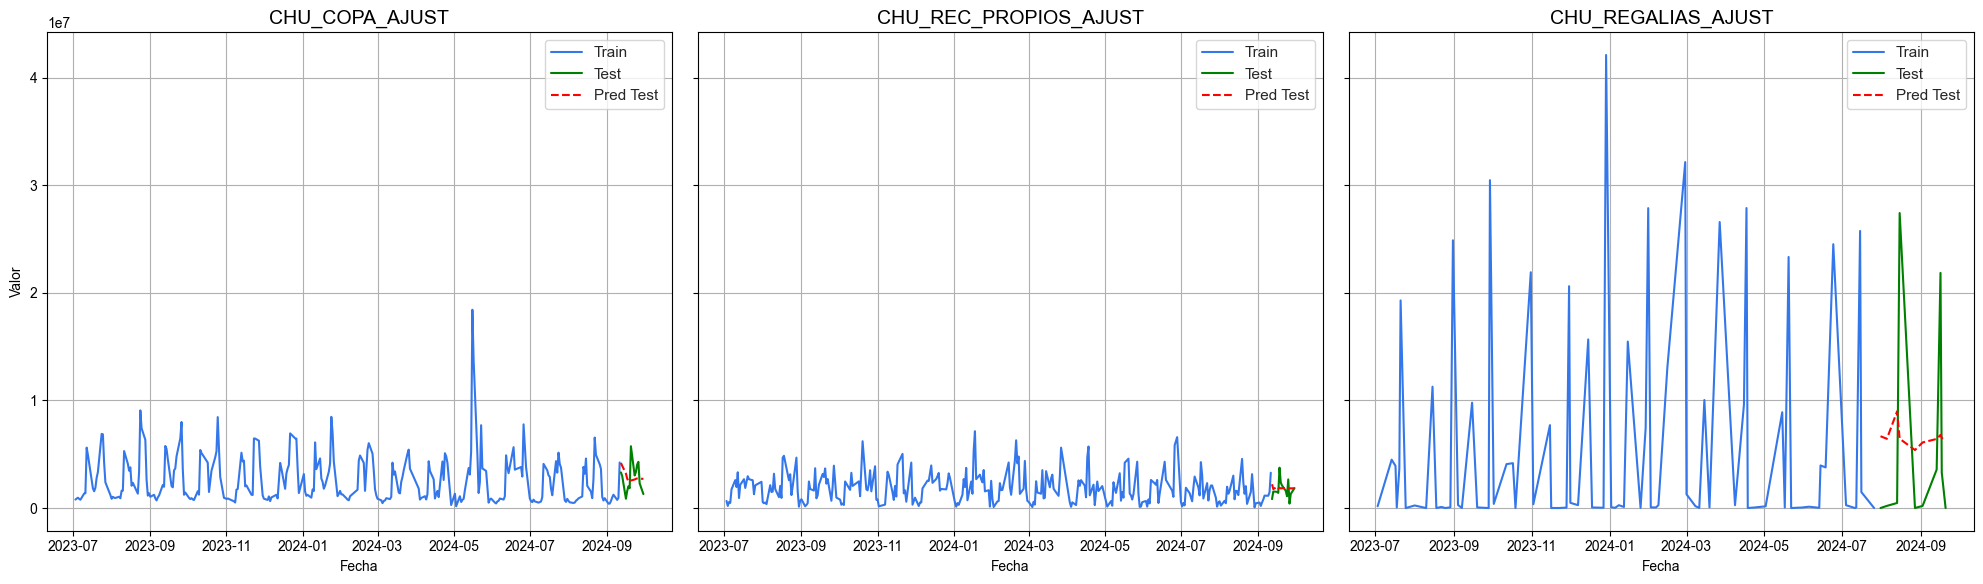

In [44]:
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    model = auto_arima(df_train, trace=False, suppress_warnings=True)
    save_model({
    "modelo": model,
    "titulo": f"aa_train_df{i}",
    "dataset": f"{df_train.name} train",
    "aic": model.aic(),
    "order": model.order})
    # Cálculo del MSE en el conjunto de entrenamiento
    mape_train = mean_absolute_percentage_error(df_train, model.predict_in_sample())

    # Obtener el DataFrame de test correspondiente
    df_test = dataframes_test[i]
    pred_test = model.predict(len(df_test))
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    pred_test.index = df_test.index
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
funciones.plot_train_test_predictions(
dataframes_train=dataframes_train,
dataframes_test=dataframes_test,
predictions_test=predictions_test,
series_names=titulos,
start_date='2023-07-01'
)

In [45]:
pd.DataFrame(results_train_test)

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        641        13        0.69       0.57   
1  CHU_REC_PROPIOS_AJUST        643        13        1.37       0.63   
2     CHU_REGALIAS_AJUST        180        10    2,241.97  18,771.07   

   mape_mean  
0       0.53  
1       0.55  
2  17,060.74

### ExponentialSmoothing

In [46]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    model = ExponentialSmoothing(df_train,trend="add",seasonal='add', seasonal_periods=21).fit()
    save_model({
    "modelo": model,
    "titulo": f"expsmoth_train_df{i}",
    "dataset" : f"{df_train.name} train",
    "aic": model.aic,
    "order": ""})
    
    df_test = dataframes_test[i]
    pred_train = model.predict(start=0, end=len(df_train) - 1)
    pred_test = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)
    pred_test.index = df_test.index
    predictions_test.append(pred_test)
    # Cálculo del MAPE para entrenamiento y prueba
    mape_train = mean_absolute_percentage_error(df_train, pred_train)
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
pd.DataFrame(results_train_test)

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        641        13        0.65       0.73   
1  CHU_REC_PROPIOS_AJUST        643        13        1.54       0.47   
2     CHU_REGALIAS_AJUST        180        10    1,635.45  20,107.96   

   mape_mean  
0       0.53  
1       0.55  
2  17,060.74

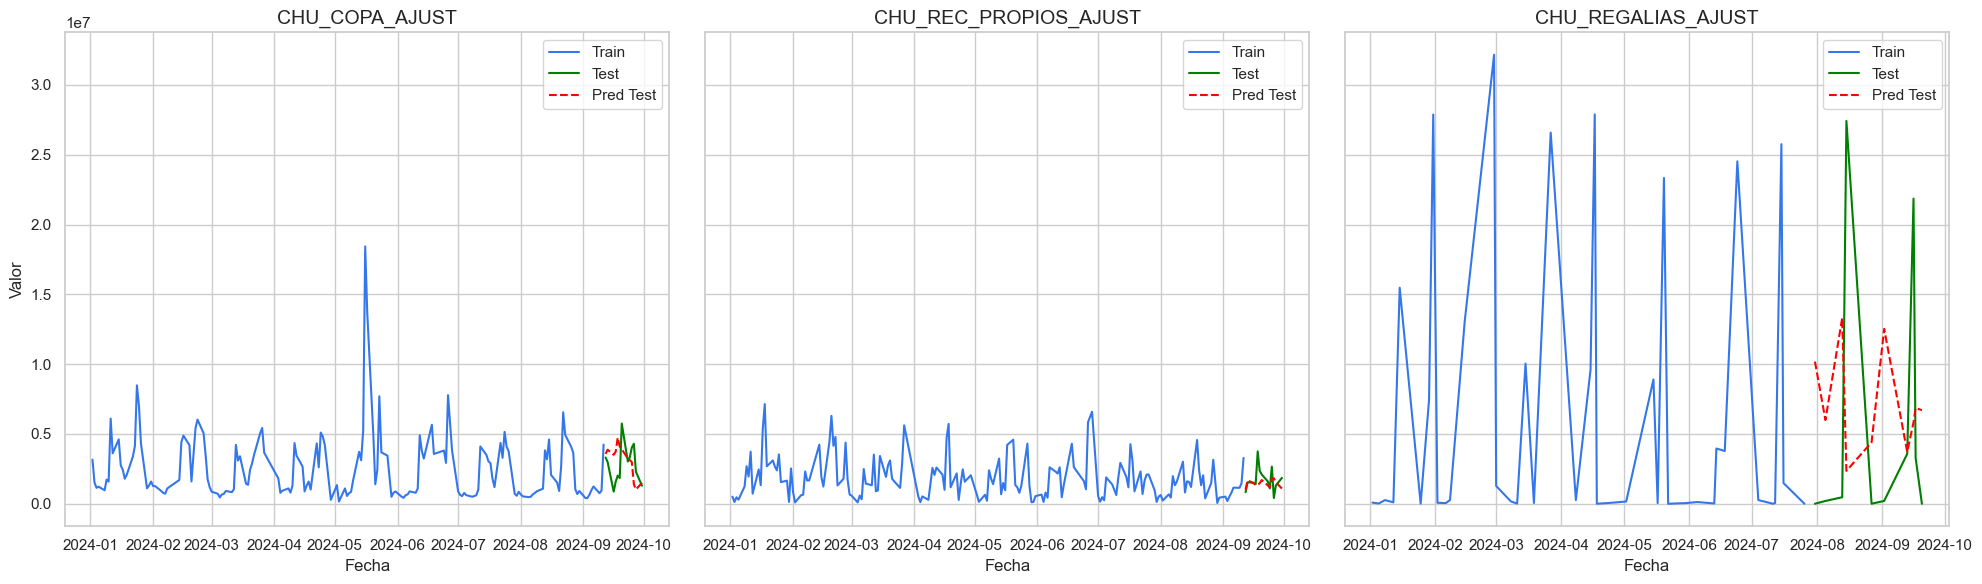

In [47]:

funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-01-01'
)

### SimpleExpSmoothing

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        641        13        0.52       0.90   
1  CHU_REC_PROPIOS_AJUST        643        13        1.53       0.47   
2     CHU_REGALIAS_AJUST        180        10    1,970.87  18,560.08   

   mape_mean  
0       0.53  
1       0.55  
2  17,060.74

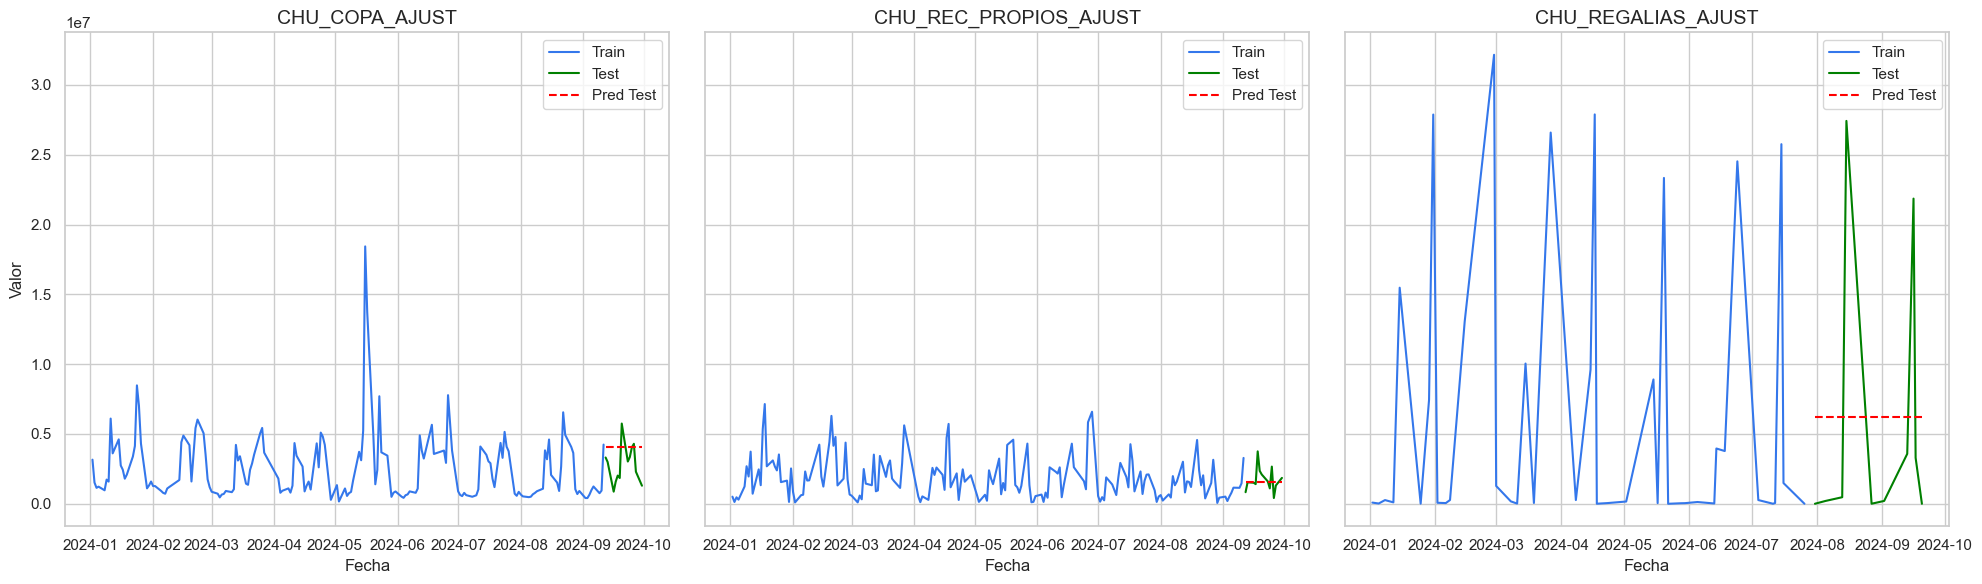

None

In [48]:
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    model = SimpleExpSmoothing(df_train).fit()
    save_model({
    "modelo": model,
    "titulo": f"simpsmoth_train_df{i}",
    "dataset" : f"{df_train.name} train",
    "aic": model.aic,
    "order": ""})
    df_test = dataframes_test[i]
    pred_train = model.predict(start=0, end=len(df_train) - 1)
    pred_test = model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)
    pred_test.index = df_test.index
    predictions_test.append(pred_test)
    # Cálculo del MAPE para entrenamiento y prueba
    mape_train = mean_absolute_percentage_error(df_train, pred_train)
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-01-01'
))

### SARIMA

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        641        13        0.62       0.42   
1  CHU_REC_PROPIOS_AJUST        643        13        1.30       0.56   
2     CHU_REGALIAS_AJUST        180        10    2,589.34  16,487.40   

   mape_mean  
0       0.53  
1       0.55  
2  17,060.74

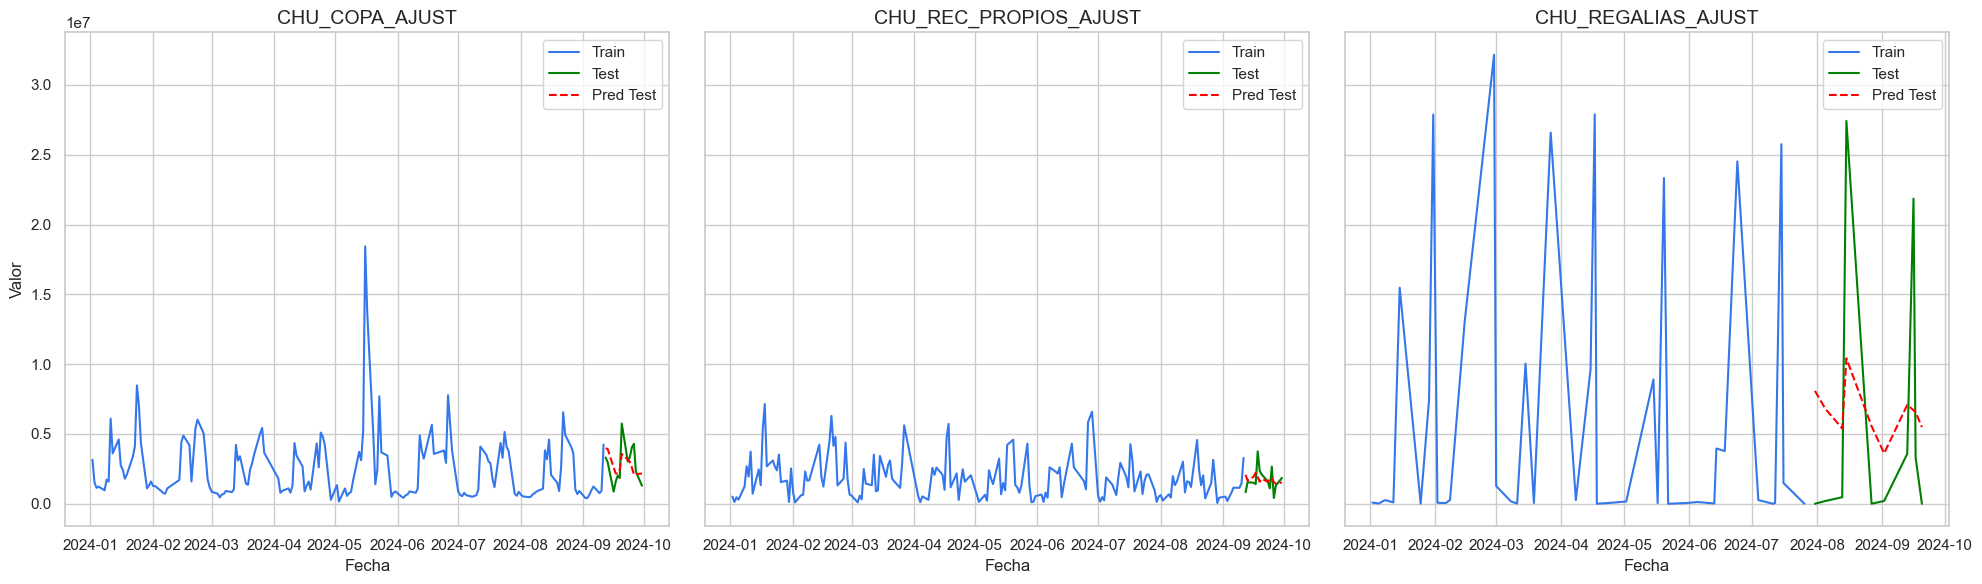

None

In [49]:
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    if i in [0,1]: 
        m = 21
    else :
        m = 6
    model = auto_arima(dataframes_train[i],
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=m,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=False, # True para imprimir resultados
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
    save_model({
    "modelo": model,
    "titulo": f"sarima_train_df{i}",
    "dataset": f"{df_train.name} train",
    "aic": model.aic(),
    "order": model.order})
    
    mape_train = mean_absolute_percentage_error(df_train, model.predict_in_sample())

    # Obtener el DataFrame de test correspondiente
    df_test = dataframes_test[i]
    pred_test = model.predict(len(df_test))
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    pred_test.index = df_test.index
    
    results_train_test.append({
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-01-01'
))

### SARIMAX

name  len_train  len_test  mape_train  mape_test  \
0         CHU_COPA_AJUST        641        13        0.45       0.49   
1  CHU_REC_PROPIOS_AJUST        643        13        0.79       0.60   
2     CHU_REGALIAS_AJUST        180        10    2,191.33  22,911.71   

   mape_mean  
0       0.53  
1       0.55  
2  17,060.74

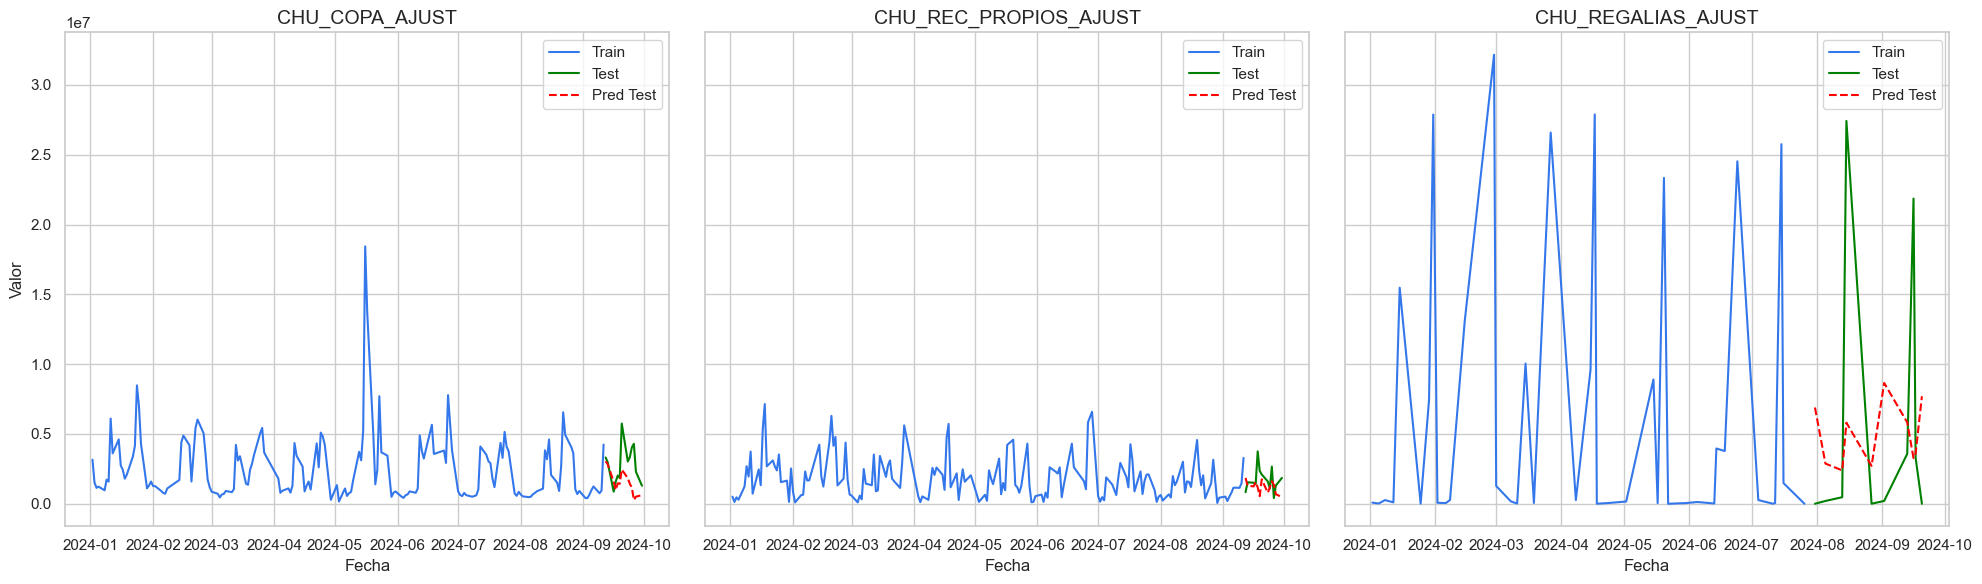

None

In [50]:
results_train_test = []
predictions_test = []
for i, df_train in enumerate(dataframes_train):
    # Entrenamiento del modelo ARIMA
    name = dataframes_train[i].name
    df_train = dataframes_train[i].to_frame()
    df_train.index = pd.to_datetime(df_train.index)
    df_test = dataframes_test[i].to_frame()
    df_test.index = pd.to_datetime(df_test.index)
    dfs = [0,1,2]
    dfs.remove(i)
    titulos_otros_df = titulos.copy()
    titulos_otros_df.remove(titulos[i])
    for j in dfs:
        df_train = df_train.join(dataframes_train[j].to_frame(), how='left')
        df_test = df_test.join(dataframes_test[j].to_frame(), how='left')
    df_train.fillna(0,inplace=True)
    df_test.fillna(0,inplace=True)
    # df_train = df_train.dropna(subset=titulos)
    # df_test = df_test.dropna(subset=titulos)
    # order de todos los df train
    orders = {row["titulo"]:row["modelo"].order for row in models if "sarima_" in row["titulo"]}
    # seasonal order de todos los df train
    sorders = {row["titulo"]:row["modelo"].seasonal_order for row in models if "sarima_" in row["titulo"]}
    
    model = sm.tsa.SARIMAX(df_train[name], order=orders[f"sarima_train_df{i}"], seasonal_order=sorders[f"sarima_train_df{i}"], exog=df_train[list(titulos_otros_df)]).fit()
    save_model({
    "modelo": model,
    "titulo": f"sarimax_train_df{i}",
    "dataset": f"{name} train",
    "aic": model.aic,
    "order": model.model_orders})
    pred_train =  model.predict(start=0, end=len(df_train)-1 ,exog=df_train[list(titulos_otros_df)])
    mape_train = mean_absolute_percentage_error(df_train[name], pred_train)

    # Obtener el DataFrame de test correspondiente
    pred_test =  model.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1 , exog=df_test[list(titulos_otros_df)])
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test[name], pred_test)
    mape_mean = mean_absolute_percentage_error(df_test[name], [df_test[name].mean()] * len(df_test))
    pred_test.index = df_test[name].index
    
    results_train_test.append({
        "name": name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_train": mape_train,
        "mape_test": mape_test,
        "mape_mean": mape_mean
    })
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2024-01-01'
))

In [67]:
display(HTML("<h2>Comparación Modelos Ajustados</h2>"))
df_models = pd.DataFrame(models)
df_models.drop(columns=["modelo"], inplace=True)
df_models.fillna("", inplace=True)
for dt in df_models["dataset"].unique():
    display(HTML(f"<h3>Modelos {dt}</h3>"))
    display(HTML(df_models[df_models["dataset"] == dt].sort_values("aic").to_html(index=False)))


In [ ]:
# from sklearn.model_selection import TimeSeriesSplit

# tscv = TimeSeriesSplit(gap=2, n_splits=5)

# train_sets = []
# test_sets = []

# for i, (train_index, test_index) in enumerate(tscv.split(dataframes[0])):
#     train_data = dataframes[0].iloc[train_index, 0]
#     test_data = dataframes[0].iloc[test_index, 0]

#     train_sets.append(train_data)
#     test_sets.append(test_data)
# 1


# train1, test1 = train_sets[0], test_sets[0]
# train2, test2 = train_sets[1], test_sets[1]
# train3, test3 = train_sets[2], test_sets[2]
# train4, test4 = train_sets[3], test_sets[3]
# train5, test5 = train_sets[4], test_sets[4]

In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(gap=2, n_splits=5)

# def graficar_split(data, tscv):
#     for i, (train_index, test_index) in enumerate(tscv.split(data)):
#         plt.figure(figsize=(12, 6))
#         plt.plot(data.index, data, label='Total', color='grey')

#         plt.plot(data.index[train_index], data.iloc[train_index], 'o-', label='Train Set', color='blue')
#         plt.plot(data.index[test_index], data.iloc[test_index], 'x--', label='Test Set', color='red')

#         plt.title(f'Particion {i + 1}')
#         plt.xlabel('Tiempo')
#         plt.ylabel('Total')
#         plt.legend()
#         plt.grid(True)
#         plt.show()
        
# graficar_split(dataframes[0], tscv)

#### metricas modelos:

In [69]:
import re

In [112]:
df_models = pd.DataFrame(models)
df_models

modelo  \
0                    ARIMA(3,0,0)(0,0,0)[0] intercept   
1                    ARIMA(2,0,2)(0,0,0)[0] intercept   
2                    ARIMA(4,0,0)(0,0,0)[0] intercept   
3   <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
4   <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
5   <statsmodels.tsa.arima.model.ARIMAResultsWrapp...   
6                   ARIMA(3,0,0)(0,0,2)[21] intercept   
7                   ARIMA(0,0,3)(0,0,2)[21] intercept   
8                    ARIMA(0,0,2)(1,0,1)[6] intercept   
9                    ARIMA(3,0,0)(0,0,0)[0] intercept   
10                   ARIMA(2,0,2)(0,0,0)[0] intercept   
11                   ARIMA(4,0,0)(0,0,0)[0] intercept   
12  <statsmodels.tsa.holtwinters.results.HoltWinte...   
13  <statsmodels.tsa.holtwinters.results.HoltWinte...   
14  <statsmodels.tsa.holtwinters.results.HoltWinte...   
15  <statsmodels.tsa.holtwinters.results.HoltWinte...   
16  <statsmodels.tsa.holtwinters.results.HoltWinte...   
17  <statsmodels.tsa.holtwinters.results.HoltWinte...   
18                  ARIMA(3,0,0)(0,0,2)[21] intercept   
19                  ARIMA(0,0,3)(0,0,2)[21] intercept   
20                   ARIMA(0,0,2)(1,0,1)[6] intercept   
21  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
22  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   
23  <statsmodels.tsa.statespace.sarimax.SARIMAXRes...   

                           dataset               titulo       aic  \
0          CHU_COPA_AJUST complete               aa_df0 20,626.54   
1   CHU_REC_PROPIOS_AJUST complete               aa_df1 20,267.19   
2      CHU_REGALIAS_AJUST complete               aa_df2  6,626.04   
3          CHU_COPA_AJUST complete             arma_df0 20,548.29   
4   CHU_REC_PROPIOS_AJUST complete             arma_df1 20,141.55   
5      CHU_REGALIAS_AJUST complete             arma_df2  6,622.50   
6          CHU_COPA_AJUST complete           sarima_df0 20,592.70   
7   CHU_REC_PROPIOS_AJUST complete           sarima_df1 20,253.23   
8      CHU_REGALIAS_AJUST complete           sarima_df2  6,626.43   
9             CHU_COPA_AJUST train         aa_train_df0 20,220.97   
10     CHU_REC_PROPIOS_AJUST train         aa_train_df1 19,872.19   
11        CHU_REGALIAS_AJUST train         aa_train_df2  6,278.47   
12            CHU_COPA_AJUST train   expsmoth_train_df0 18,642.98   
13     CHU_REC_PROPIOS_AJUST train   expsmoth_train_df1 18,191.29   
14        CHU_REGALIAS_AJUST train   expsmoth_train_df2  5,854.85   
15            CHU_COPA_AJUST train  simpsmoth_train_df0 18,569.58   
16     CHU_REC_PROPIOS_AJUST train  simpsmoth_train_df1 18,123.60   
17        CHU_REGALIAS_AJUST train  simpsmoth_train_df2  5,808.00   
18            CHU_COPA_AJUST train     sarima_train_df0 20,190.16   
19     CHU_REC_PROPIOS_AJUST train     sarima_train_df1 19,858.84   
20        CHU_REGALIAS_AJUST train     sarima_train_df2  6,279.56   
21            CHU_COPA_AJUST train    sarimax_train_df0 20,327.62   
22     CHU_REC_PROPIOS_AJUST train    sarimax_train_df1 20,001.45   
23        CHU_REGALIAS_AJUST train    sarimax_train_df2  6,308.60   

                                                order seasonal_order  
0                                           (3, 0, 0)            NaN  
1                                           (2, 0, 2)            NaN  
2                                           (4, 0, 0)            NaN  
3                                           (7, 0, 4)            NaN  
4                                           (2, 0, 7)            NaN  
5                                           (2, 0, 2)            NaN  
6                                           (3, 0, 0)  (0, 0, 2, 21)  
7                                           (0, 0, 3)  (0, 0, 2, 21)  
8                                           (0, 0, 2)   (1, 0, 1, 6)  
9                                           (3, 0, 0)            NaN  
10                                          (2, 0, 2)            NaN  
11                                         

In [143]:
results = []
for row in models:
    model = row["modelo"]
    n_df = re.search(r"df(\d+)", row["titulo"]).group(1)
    i = int(n_df)
    dataset = dataframes[i].name
    df_test = dataframes_test[i]
    if "sarimax" in row["titulo"]:
        dfs = [0,1,2]
        dfs.remove(i)
        titulos_otros_df = titulos.copy()
        titulos_otros_df.remove(titulos[i])
        df_test = dataframes_test[i].to_frame()
        for j in dfs:
            df_test = df_test.join(dataframes_test[j].to_frame(), how='left')
        df_test.fillna(0,inplace=True)
        pred = model.get_forecast(steps=len(df_test),exog=df_test[list(titulos_otros_df)])
        pred = pred.predicted_mean
        df_test = dataframes_test[i]
    elif "arma_" in row["titulo"]:
        pred = model.get_forecast(steps=len(df_test))
        pred = pred.predicted_mean
    elif "smoth" in row["titulo"]:
          pred = model.forecast(steps=len(df_test))
        
    else:
        pred = model.predict(len(df_test))
    pred.index = df_test.index
    MSE = mean_squared_error(df_test, pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(df_test, pred)
    MAPE = np.mean(np.abs((df_test - pred) / df_test)) * 100

    results.append({
    "Dataset": dataset,
    "titulo": row["titulo"],
    "AIC": row["aic"],
    "MSE": MSE,
    "RMSE": RMSE,
    "MAE": MAE,
    "MAPE": MAPE,
    "MAPE_MEAN": mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))*100
    })
results_df = pd.DataFrame(results)
for dataset in results_df["Dataset"].unique():
    display(HTML(f"<h3>Resultados para {dataset}</h3>"))
    display(HTML(results_df[results_df["Dataset"] == dataset].sort_values("MSE").to_html(index=False)))

In [131]:
dataframes_test.columns

AttributeError: 'list' object has no attribute 'columns'

Relación cruzada

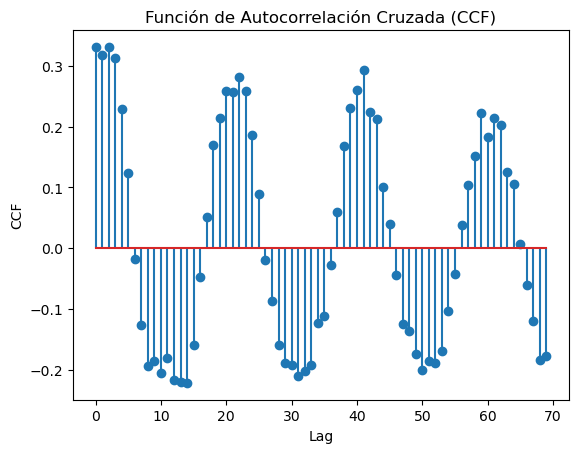

In [179]:
from statsmodels.tsa.stattools import ccf

MediaDestino2_array = train_sarimax['CHU_COPA_AJUST'].values
MediaDestino1_array = train_sarimax['CHU_REC_PROPIOS_AJUST'].values

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Calculo de CCF
lags = 70
cross_corr = ccf(MediaDestino2_array, MediaDestino1_array)[:lags]

# Grafico de CCF
plt.stem(range(lags), cross_corr)  # Eliminar el argumento 'use_line_collection'
plt.title('Función de Autocorrelación Cruzada (CCF)')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

## Ejercicio 8

Efectuar un Análisis de Diagnóstico de las series temporales (Análisis sobre los Residuos del modelo, análisis gráfico de FAC, test de Ljung-Box, etc.).

In [15]:
def plotear_residuos(modelo, titulo):
    if titulo.startswith(("aa_","sarima_")):
        modelo.resid().plot(figsize=(20,5))
    else:
        modelo.resid.plot(figsize=(20,5))
    plt.title(titulo,size=24)
    plt.show()

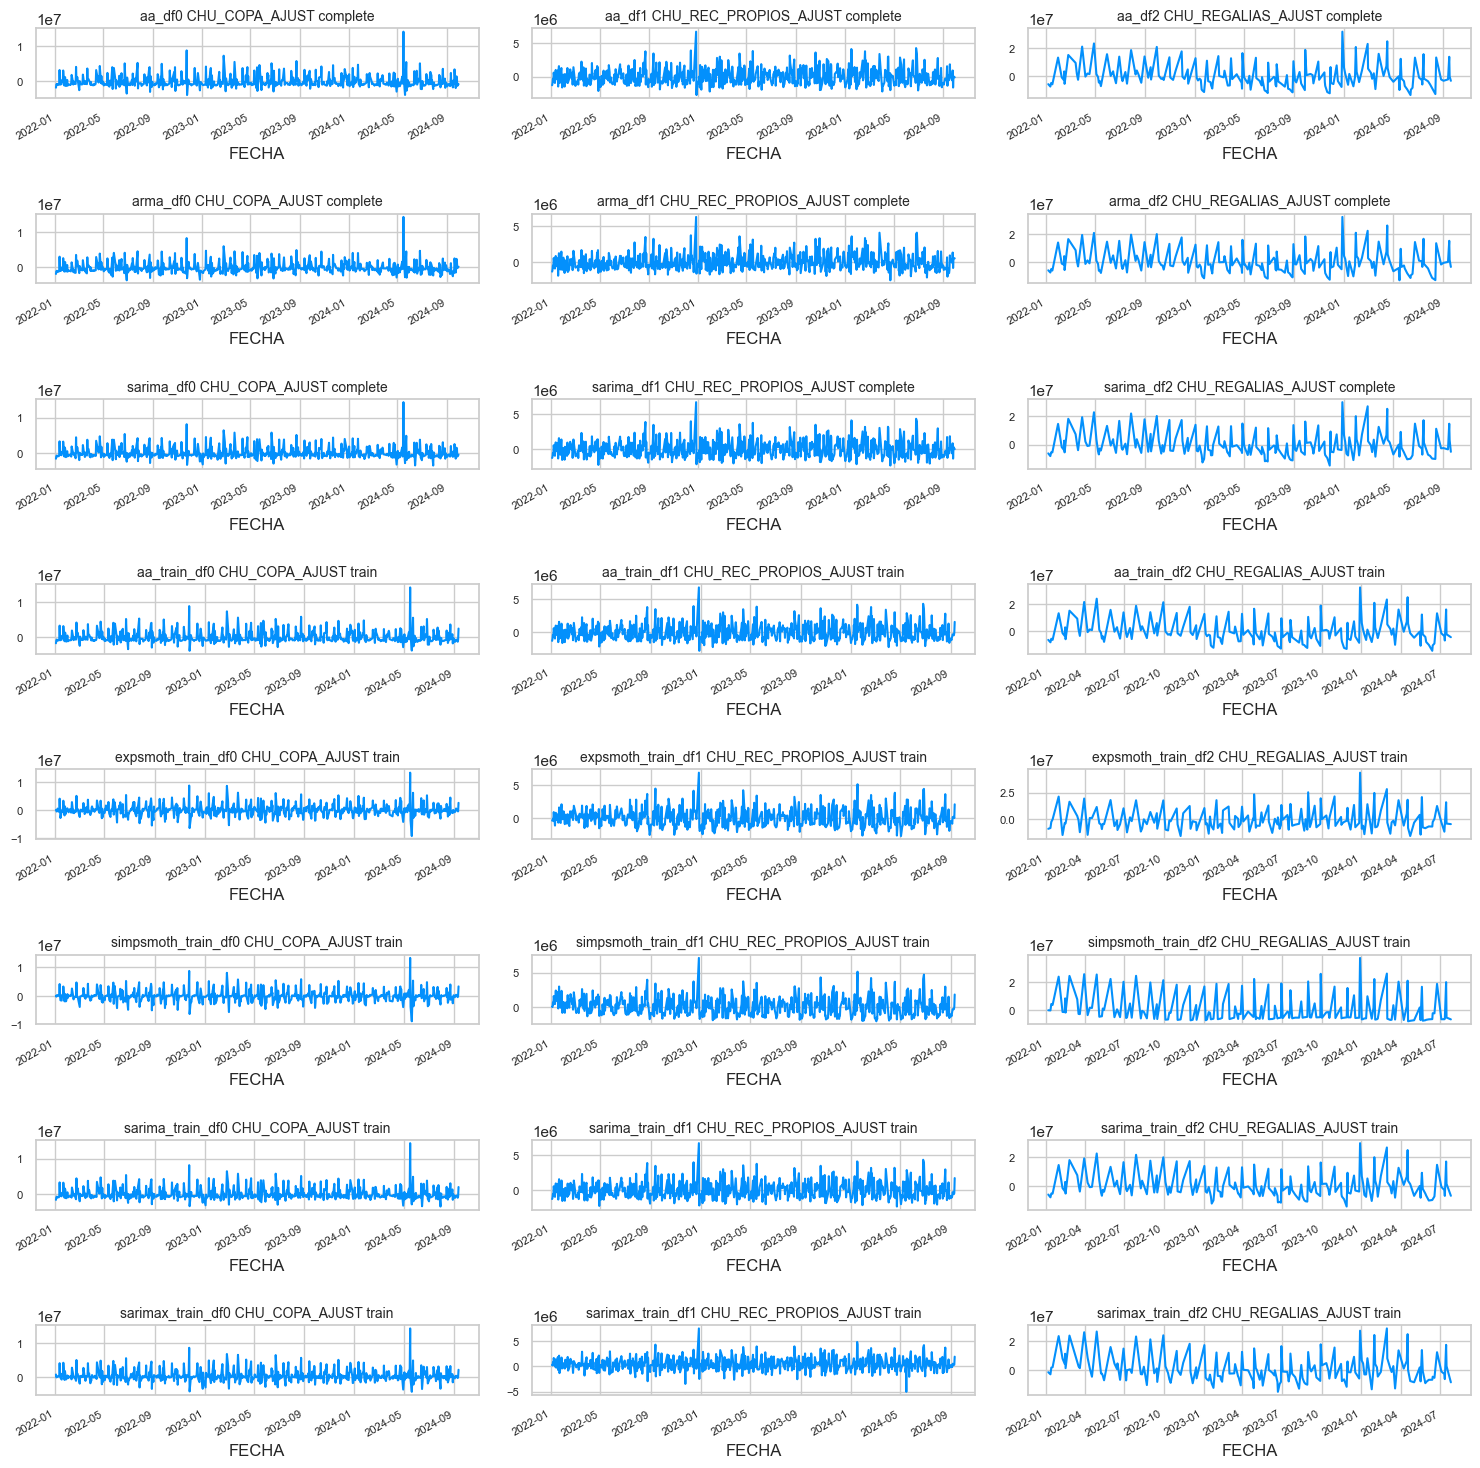

In [42]:
def plotear_residuos_en_grilla(models, filas=3, columnas=3):
    # Calcula la grilla en función de la cantidad de modelos
    total_modelos = len(models)
    filas = int(np.ceil(total_modelos / columnas))  # Calcula filas necesarias
    fig, axs = plt.subplots(filas, columnas, figsize=(15, 15))  # Tamaño total del gráfico
    axs = axs.ravel()  # Aplana los ejes para iterar fácilmente
    
    for i, modelo in enumerate(models):
        try:
            titulo = modelo["titulo"]
            if titulo.startswith(("aa_", "sarima_")):
                modelo["modelo"].resid().plot(ax=axs[i], color='#0390fc')
            else:
                modelo["modelo"].resid.plot(ax=axs[i], color='#0390fc')
            axs[i].set_title(f"{titulo} {modelo["dataset"]}", size=10)
            axs[i].tick_params(axis='both', which='both', labelsize=8)
        except Exception as e:
            axs[i].text(0.5, 0.5, f"Error en {modelo['titulo']}", ha='center', va='center')
            axs[i].axis('off')  # Oculta el gráfico en caso de error

    # Oculta ejes no usados si la grilla es más grande que el número de modelos
    for j in range(i + 1, filas * columnas):
        axs[j].axis('off')

    plt.tight_layout()  # Ajusta los espacios entre gráficos
    plt.show()

# Llama a la función con los modelos y el tamaño de grilla deseado
plotear_residuos_en_grilla(models, filas=3, columnas=3)

#### Gráficos PAC y PACF de los residuos

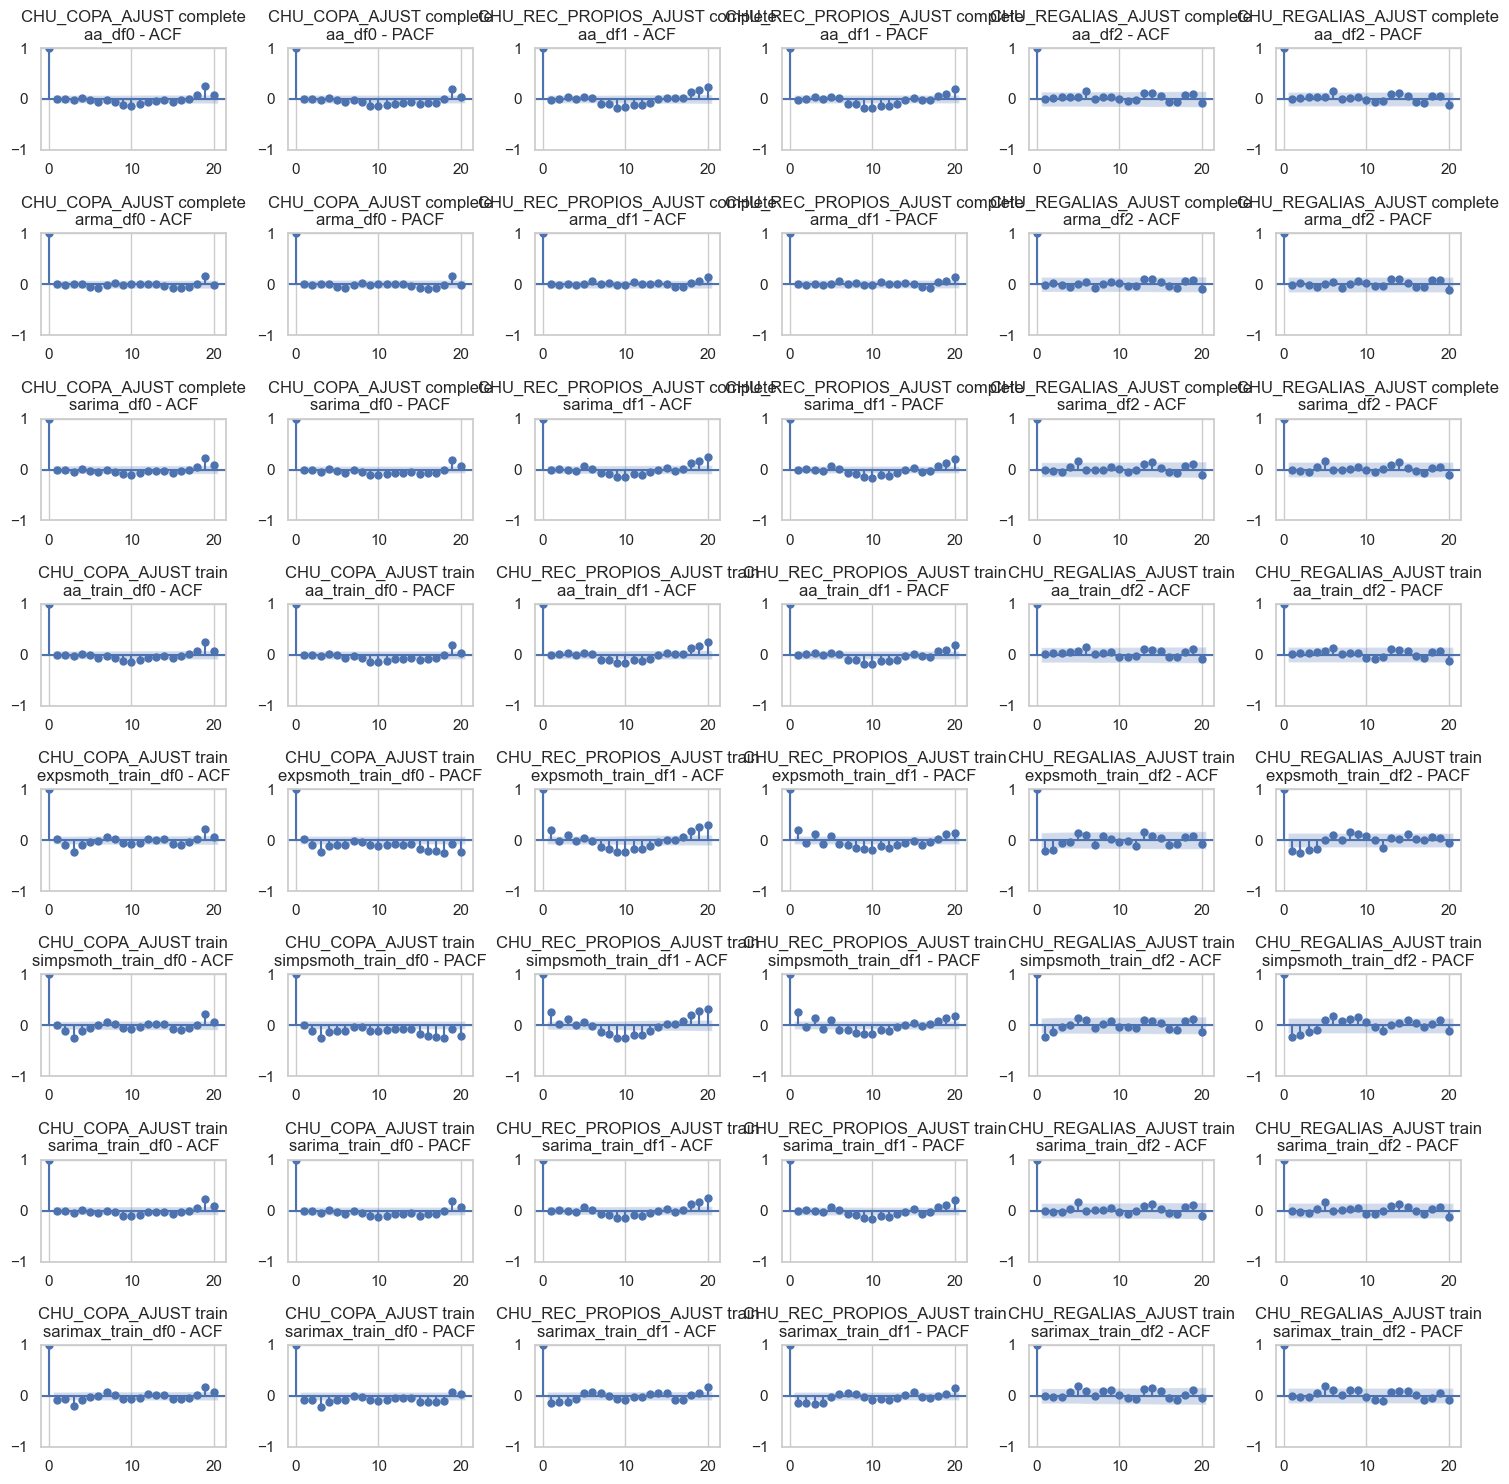

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf_en_grilla(models, filas=3, columnas=3):
    total_modelos = len(models)
    filas = int(np.ceil(total_modelos / columnas))  # Calcula filas necesarias
    fig, axs = plt.subplots(filas, columnas * 2, figsize=(15, 15))  # Multiplica columnas por 2 para ACF y PACF
    axs = axs.reshape(filas, columnas * 2)  # Reorganiza los ejes para acceso ordenado

    for i, modelo in enumerate(models):
        try:
            titulo = modelo["titulo"]
            # Determina los residuos según el tipo de modelo
            residuals = modelo["modelo"].resid() if titulo.startswith(("aa_", "sarima_")) else modelo["modelo"].resid

            # Calcular la posición en la grilla
            row, col = divmod(i, columnas)
            plot_acf(residuals, ax=axs[row, col * 2], lags=20)
            axs[row, col * 2].set_title(f'{modelo["dataset"]}\n{titulo} - ACF', size=12)

            plot_pacf(residuals, ax=axs[row, col * 2 + 1], lags=20)
            axs[row, col * 2 + 1].set_title(f'{modelo["dataset"]}\n{titulo} - PACF', size=12)
        except Exception as e:
            # Si hay un error, desactiva ambos subplots
            axs[row, col * 2].text(0.5, 0.5, f"Error en {titulo}", ha='center', va='center')
            axs[row, col * 2].axis('off')
            axs[row, col * 2 + 1].axis('off')

    # Oculta los ejes no usados
    for j in range(i + 1, filas * columnas):
        axs[j // columnas, (j % columnas) * 2].axis('off')
        axs[j // columnas, (j % columnas) * 2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

# Llama a la función con el conjunto de modelos
plot_acf_pacf_en_grilla(models, filas=3, columnas=3)


#### Análisis diagnóstico de los residuos: QQPlot - Normalizacion - Correlograma

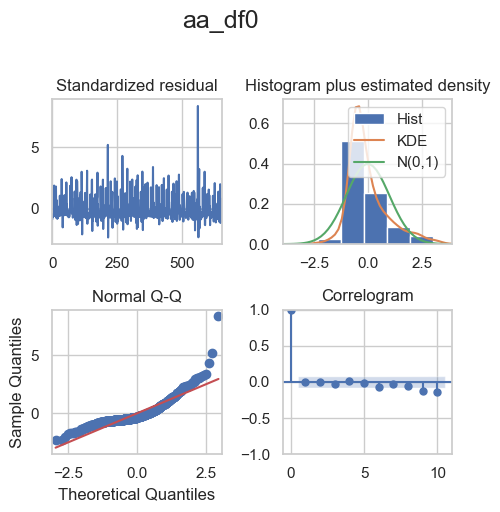

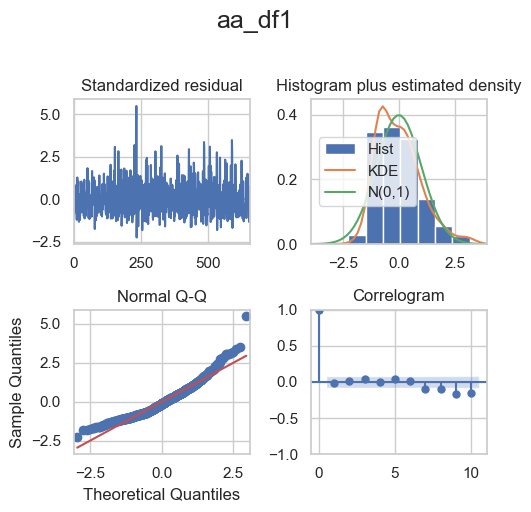

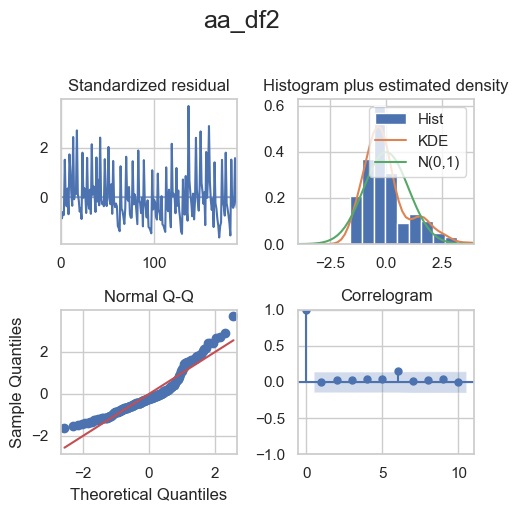

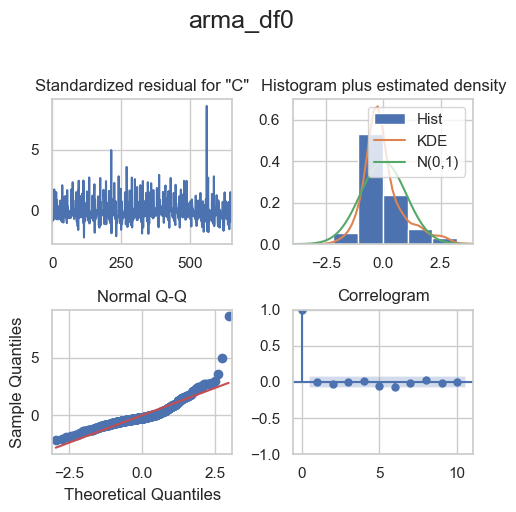

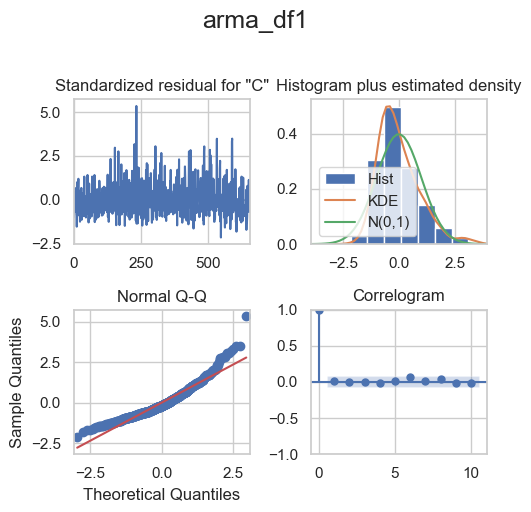

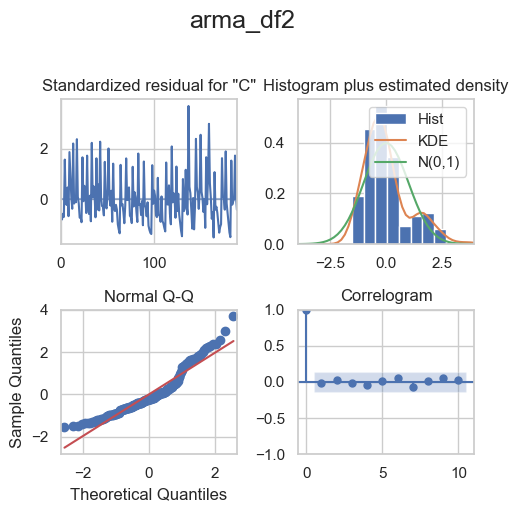

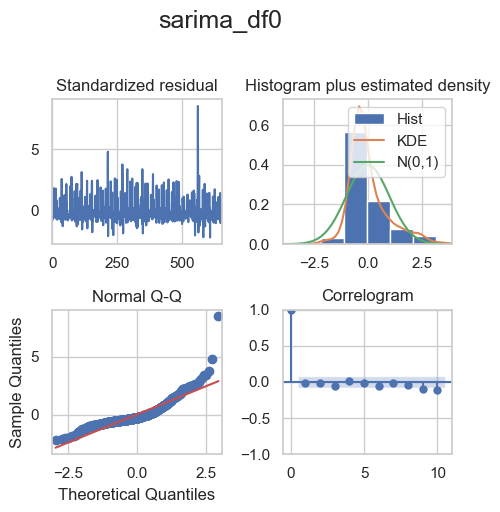

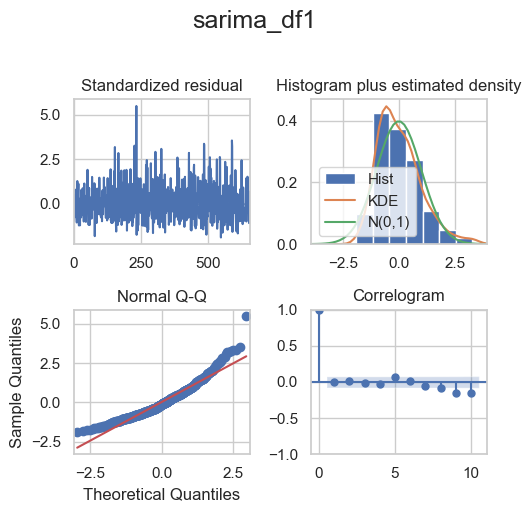

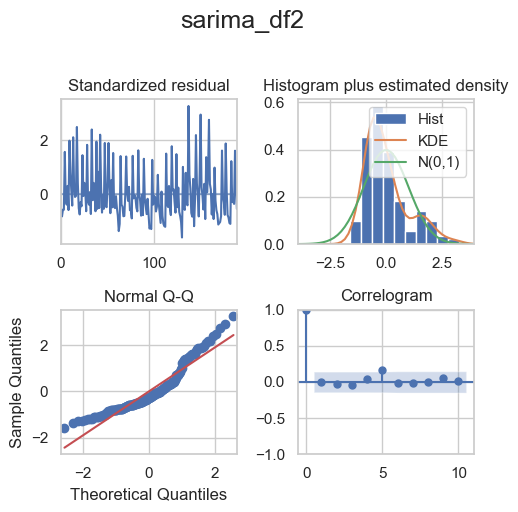

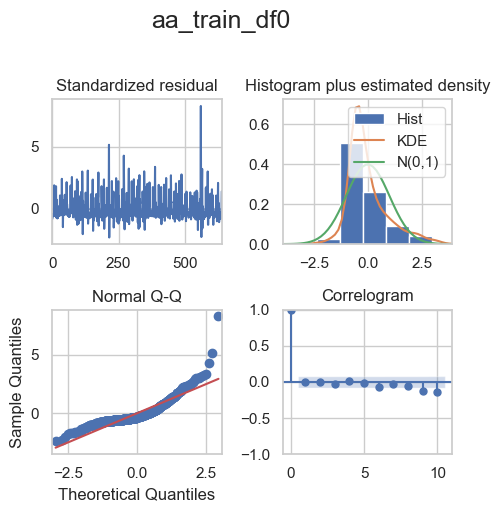

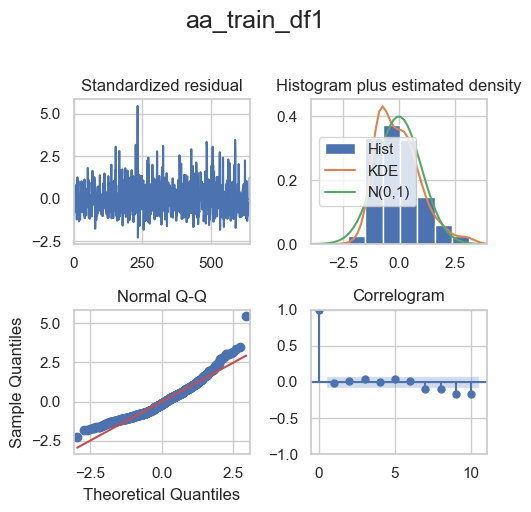

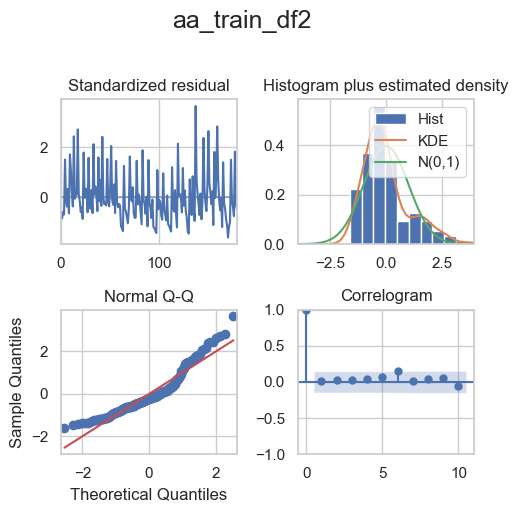

Error en expsmoth_train_df0
Error en expsmoth_train_df1
Error en expsmoth_train_df2
Error en simpsmoth_train_df0
Error en simpsmoth_train_df1
Error en simpsmoth_train_df2


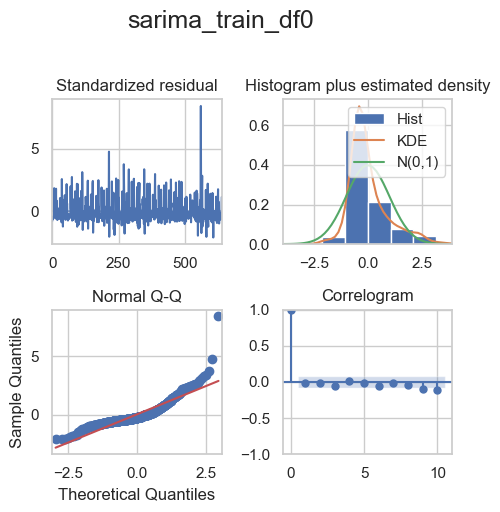

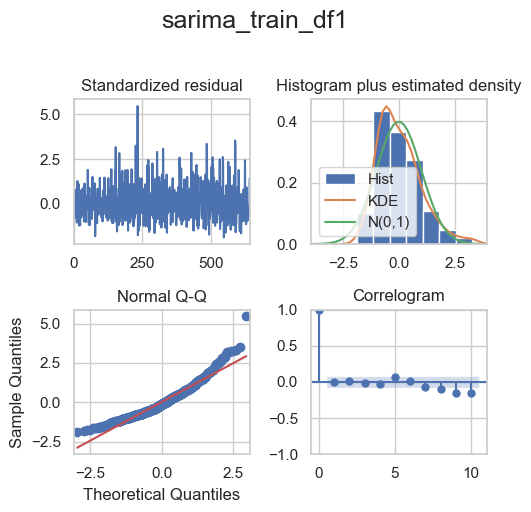

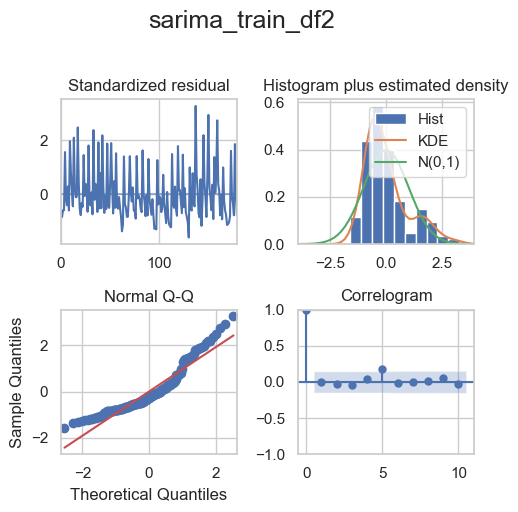

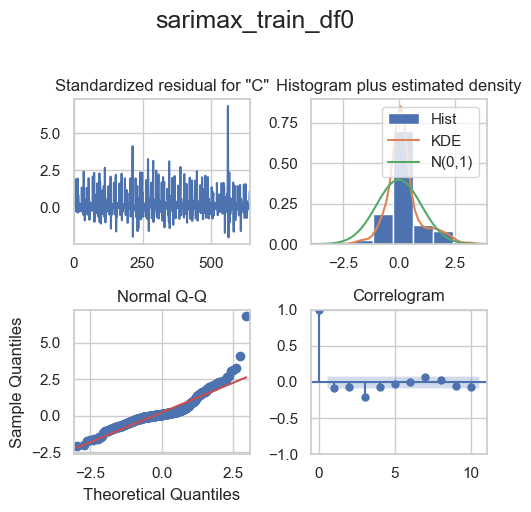

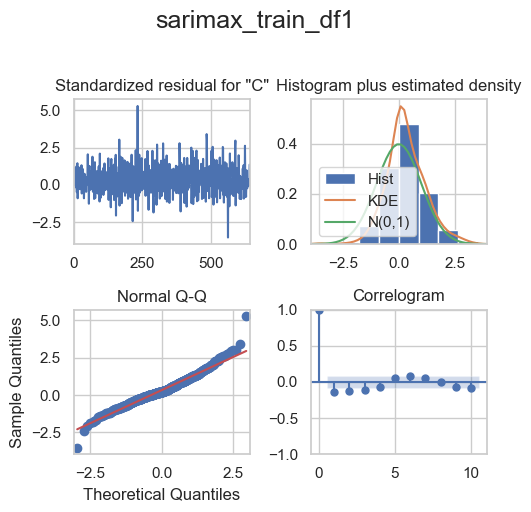

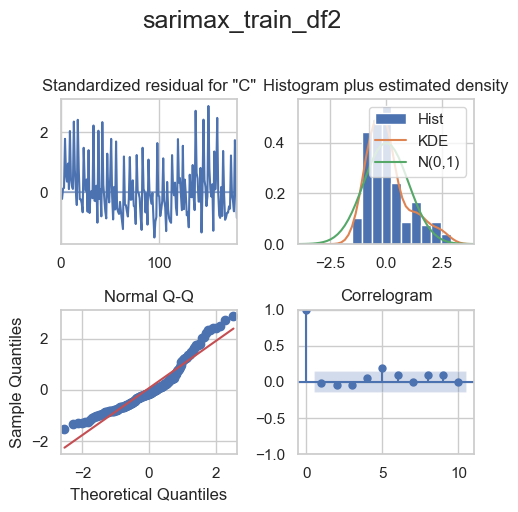

In [ ]:
def plotear_analisis_diagnostico_residuos(modelo, titulo):
    fig = modelo.plot_diagnostics(figsize=(5, 5))
    
    # Agregar un título general a la figura
    fig.suptitle(titulo, size=18, y=1.02)  # y=1.02 ajusta la posición vertical del título
    
    plt.tight_layout()  # Asegura que los subgráficos no se solapen
    plt.show()

for modelo in models:
    try:
        plotear_analisis_diagnostico_residuos(modelo["modelo"],modelo["titulo"])
    except:
        print(f"Error en {modelo['titulo']}")

#### Incorrelación de los residuos

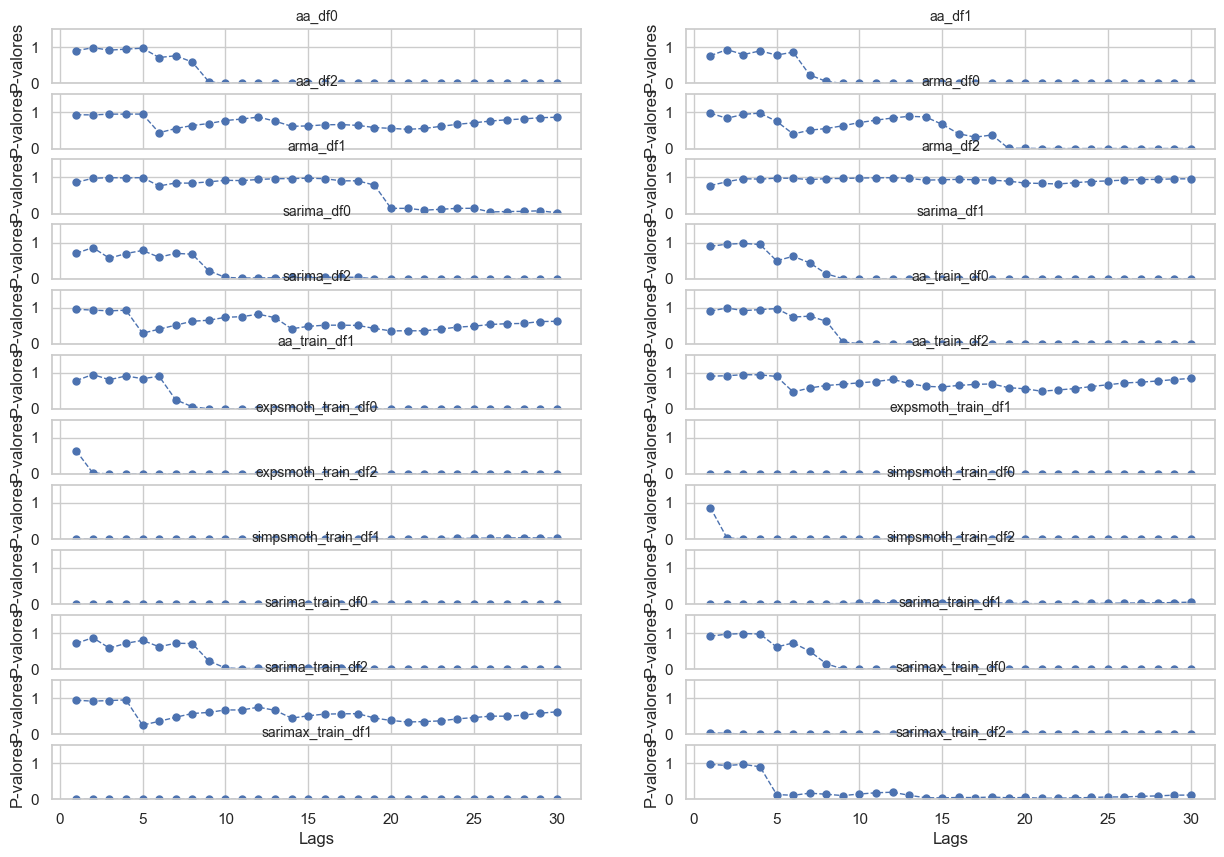

In [61]:
def plotear_incorrelacion_en_grilla(models, filas=2, columnas=2):
    total_modelos = len(models)
    filas = int(np.ceil(total_modelos / columnas))  # Calcula el número de filas necesarias
    fig, axs = plt.subplots(filas, columnas, figsize=(15, 10))  # Tamaño total de la figura para la grilla
    axs = axs.ravel()  # Aplana la matriz de ejes para iterar fácilmente

    for i, modelo in enumerate(models):
        try:
            titulo = modelo["titulo"]
            # Obtener los residuos según el tipo de modelo
            residuals = modelo["modelo"].resid() if titulo.startswith(("aa_", "sarima_")) else modelo["modelo"].resid
            
            # Calcular la incorrelación usando la prueba Ljung-Box
            Incorr_residuos_modelo = sm.stats.acorr_ljungbox(residuals, lags=30)
            
            # Graficar los p-valores de la incorrelación en el subplot correspondiente
            axs[i].plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=5, linestyle='--', linewidth=1)
            axs[i].set_title(f"{titulo}", fontsize=10)
            axs[i].set_ylabel("P-valores")
            axs[i].set_xlabel("Lags")
            
            # Ajustar el límite del eje y para que sea más grande
            axs[i].set_ylim(0, 1.5)  # Configura un límite superior de 1.2 para ver mejor los p-valores
        except Exception as e:
            axs[i].text(0.5, 0.5, f"Error en {titulo}", ha='center', va='center', fontsize=10)
            axs[i].axis('off')  # Desactiva el subplot si hay error

    # Oculta ejes no utilizados en caso de que la grilla tenga más espacios que modelos
    for j in range(i + 1, filas * columnas):
        axs[j].axis('off')

    plt.tight_layout()  # Ajusta los espacios para evitar solapamiento
    plt.show()

# Llama a la función con los modelos y el tamaño de grilla deseado
plotear_incorrelacion_en_grilla(models, filas=2, columnas=2)

In [ ]:
def plotear_incorrelacion(modelo, titulo):
    if titulo.startswith(("aa_","sarima_")):
        residuals = modelo.resid()
    else:
        residuals = modelo.resid
    Incorr_residuos_modelo=sm.stats.acorr_ljungbox(residuals, lags=30)

    
    plt.plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
    plt.title(f"Grafico de incorrelacion de los residuos del modelo {titulo}")
    plt.ylabel("P-valores")
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    
for modelo in models:
    try:
        plotear_incorrelacion(modelo["modelo"],modelo["titulo"])
    except:
        print(f"Error en {modelo['titulo']}")

#### Test de Box-Pierce para analizar residuos

In [68]:
from statsmodels.tsa.stattools import acf
from scipy.stats import chi2
resultados_boxp = []
def test_de_box_pierce(modelo, titulo, aic):
    if titulo.startswith(("aa_","sarima_")):
        residuals = modelo.resid()
    else:
        residuals = modelo.resid
    # Test Box-Pierce
    lags = 10

    acf_values = acf(residuals, nlags=lags, fft=False)
    
    # Calculamos el estadistico de prueba Q de Box-Pierce
    n = len(residuals)
    Q = n * np.sum(np.square(acf_values[1:lags+1]))
    p_value = 1 - chi2.cdf(Q, df=lags)
    
    alpha = 0.05
    resultados_boxp.append({
        "titulo": titulo,
        "Q": Q,
        "p_value": p_value,
        "autocorrelación":p_value < alpha,
        "aic": aic
        
    })

for modelo in models:
    try:
        test_de_box_pierce(modelo["modelo"],modelo["titulo"],modelo["aic"])
    except:
        print(f"Error en {modelo['titulo']}")
resultados_boxp = pd.DataFrame(resultados_boxp)
display(HTML("<h2>Test de Box-Pierce</h2>"))
display(resultados_boxp)

titulo      Q  p_value  autocorrelación       aic
0                aa_df0  28.39     0.00             True 20,626.54
1                aa_df1  50.52     0.00             True 20,267.19
2                aa_df2   6.20     0.80            False  6,626.04
3              arma_df0   6.98     0.73            False 20,548.29
4              arma_df1   4.45     0.92            False 20,141.55
5              arma_df2   2.75     0.99            False  6,622.50
6            sarima_df0  18.98     0.04             True 20,592.70
7            sarima_df1  41.89     0.00             True 20,253.23
8            sarima_df2   6.68     0.76            False  6,626.43
9          aa_train_df0  28.83     0.00             True 20,220.97
10         aa_train_df1  50.65     0.00             True 19,872.19
11         aa_train_df2   6.75     0.75            False  6,278.47
12   expsmoth_train_df0  58.77     0.00             True 18,642.98
13   expsmoth_train_df1 138.85     0.00             True 18,191.29
14   expsmoth_train_df2  24.26     0.01             True  5,854.85
15  simpsmoth_train_df0  64.79     0.00             True 18,569.58
16  simpsmoth_train_df1 164.98     0.00             True 18,123.60
17  simpsmoth_train_df2  20.66     0.02             True  5,808.00
18     sarima_train_df0  19.35     0.04             True 20,190.16
19     sarima_train_df1  41.82     0.00             True 19,858.84
20     sarima_train_df2   7.27     0.70            False  6,279.56
21    sarimax_train_df0  46.66     0.00             True 20,327.62
22    sarimax_train_df1  49.84     0.00             True 20,001.45
23    sarimax_train_df2  14.02     0.17            False  6,308.60

In [23]:
resultados_boxp[resultados_boxp["autocorrelación"]==False].sort_values("aic")

titulo    Q  p_value  autocorrelación       aic
8  aa_train_df2 6.75     0.75            False  6,278.47
5      arma_df2 2.75     0.99            False  6,622.50
2        aa_df2 6.20     0.80            False  6,626.04
4      arma_df1 4.45     0.92            False 20,141.55
3      arma_df0 6.98     0.73            False 20,548.29

## Ejercicio 9

Pronosticar con el modelo seleccionado para cada serie para una ventana temporal razonable, en función de la periodicidad y el comportamiento de las mismas.

*El único modelo cuyos residuos estan incorrelacionados es el ARIMA(7,6) con la serie diferenciada una vez. A continuación vemos la predicción.*

In [24]:
import re
data_models = []
for model in models:
    n_df = re.search(r"df(\d+)", model["titulo"]).group(1)
    dataset = dataframes[int(n_df)].name
    aic = model["aic"]
    boxp = resultados_boxp[resultados_boxp["titulo"]==model["titulo"]]["autocorrelación"].values[0]
    modelo = model["modelo"]
    data_models.append({"dataset":dataset, "titulo":model["titulo"], "aic":aic, "boxp":boxp, "modelo":modelo})
data_models = pd.DataFrame(data_models).sort_values("aic",ascending=True)
data_models[data_models["boxp"]==False]

dataset        titulo       aic   boxp  \
8     CHU_REGALIAS_AJUST  aa_train_df2  6,278.47  False   
5     CHU_REGALIAS_AJUST      arma_df2  6,622.50  False   
2     CHU_REGALIAS_AJUST        aa_df2  6,626.04  False   
4  CHU_REC_PROPIOS_AJUST      arma_df1 20,141.55  False   
3         CHU_COPA_AJUST      arma_df0 20,548.29  False   

                                              modelo  
8                   ARIMA(4,0,0)(0,0,0)[0] intercept  
5  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
2                   ARIMA(4,0,0)(0,0,0)[0] intercept  
4  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...  
3  <statsmodels.tsa.arima.model.ARIMAResultsWrapp...

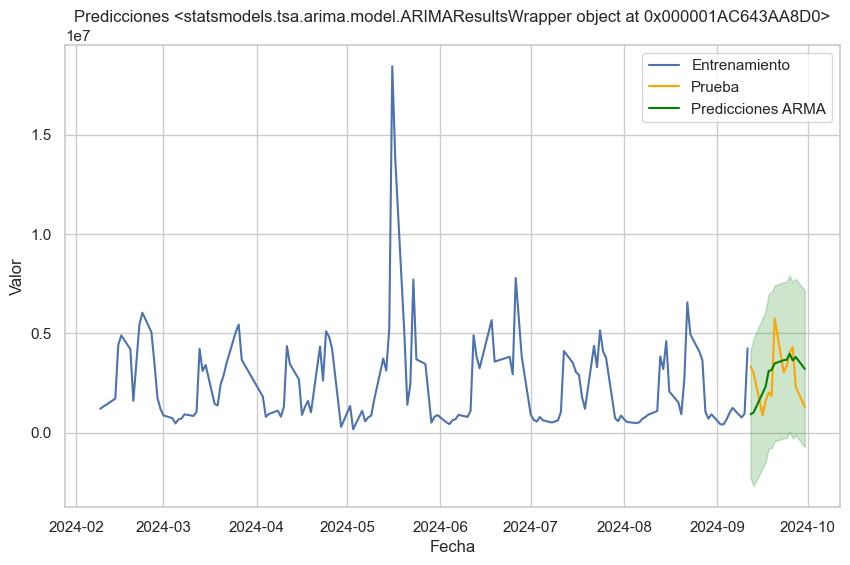

In [25]:
modelo_copa = data_models[data_models["titulo"]=="arma_df0"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
#forecast_regalias, conf_int  = modelo_regalias.predict(n_periods=len(dataframes_test[0]),return_conf_int=True)
forecast_copa = modelo_copa.get_forecast(steps=len(dataframes_test[0]))  # Donde len(dataframes_test[0]) es el número de pasos de predicción
forecast_df = forecast_copa.predicted_mean  # Obtiene las predicciones
conf_int = forecast_copa.conf_int()  # Obtiene los intervalos de confianza
# Crear un índice de fechas para el pronóstico
forecast_df = pd.DataFrame(forecast_df)

forecast_df.index = dataframes_test[0].index

plt.figure(figsize=(10, 6))
plt.plot(dataframes_train[0].iloc[500:].index, dataframes_train[0].iloc[500:], label='Entrenamiento')
plt.plot(dataframes_test[0].index, dataframes_test[0], label='Prueba', color='orange')
plt.plot(forecast_df.index, forecast_df["predicted_mean"], label='Predicciones ARMA', color='green')
plt.fill_between(dataframes_test[0].index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones {modelo_copa}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

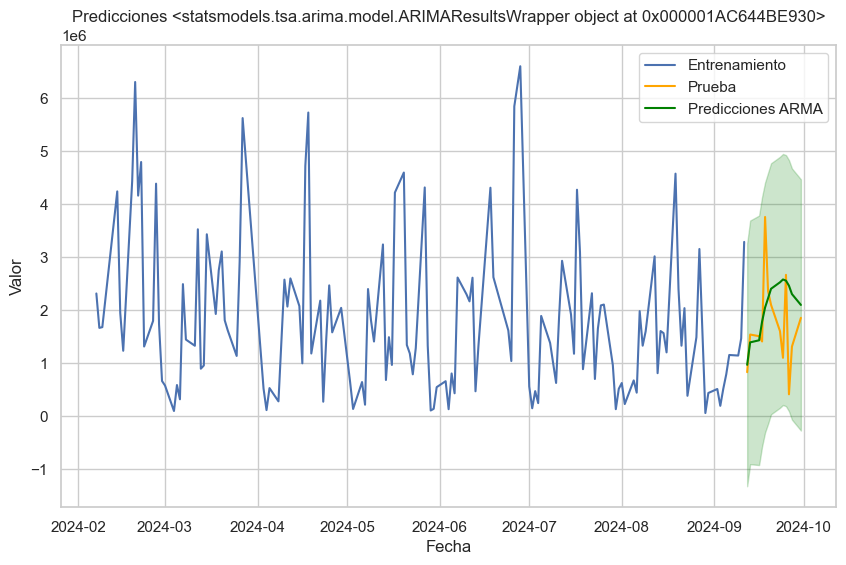

In [26]:
modelo_recp = data_models[data_models["titulo"]=="arma_df1"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
#forecast_regalias, conf_int  = modelo_regalias.predict(n_periods=len(dataframes_test[0]),return_conf_int=True)
forecast_recp = modelo_recp.get_forecast(steps=len(dataframes_test[1]))  # Donde len(dataframes_test[0]) es el número de pasos de predicción
forecast_df = forecast_recp.predicted_mean  # Obtiene las predicciones
conf_int = forecast_recp.conf_int()  # Obtiene los intervalos de confianza
# Crear un índice de fechas para el pronóstico
forecast_df = pd.DataFrame(forecast_df)

forecast_df.index = dataframes_test[1].index

plt.figure(figsize=(10, 6))
plt.plot(dataframes_train[1].iloc[500:].index, dataframes_train[1].iloc[500:], label='Entrenamiento')
plt.plot(dataframes_test[1].index, dataframes_test[1], label='Prueba', color='orange')
plt.plot(forecast_df.index, forecast_df["predicted_mean"], label='Predicciones ARMA', color='green')
plt.fill_between(dataframes_test[1].index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones {modelo_recp}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

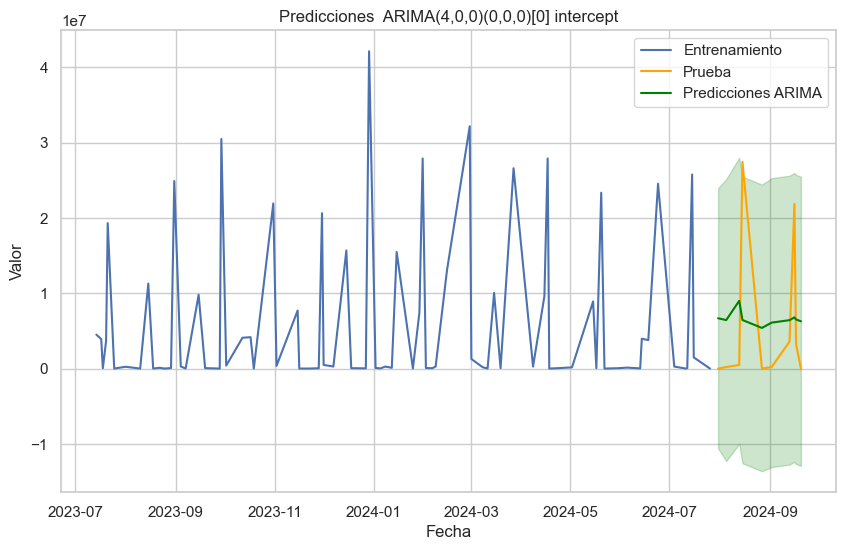

In [27]:
modelo_regalias = data_models[data_models["titulo"]=="aa_train_df2"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
forecast_regalias, conf_int  = modelo_regalias.predict(n_periods=len(dataframes_test[2]),return_conf_int=True)

# Crear un índice de fechas para el pronóstico
forecast_regalias_df = pd.DataFrame(forecast_regalias,columns=["CHU_REGALIAS_AJUST"])
forecast_regalias_df.index = dataframes_test[2].index

plt.figure(figsize=(10, 6))
plt.plot(dataframes_train[2].iloc[100:].index, dataframes_train[2].iloc[100:], label='Entrenamiento')
plt.plot(dataframes_test[2].index, dataframes_test[2], label='Prueba', color='orange')
plt.plot(forecast_regalias_df.index, forecast_regalias_df["CHU_REGALIAS_AJUST"], label='Predicciones ARIMA', color='green')
plt.fill_between(dataframes_test[2].index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones {modelo_regalias}')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [29]:
forecast_recp

In [31]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    mape_mean = mean_absolute_percentage_error(serie_test, [serie_test.mean()] * len(serie_test))
    mape = mean_absolute_percentage_error(serie_test,serie_pred)
    print(f'MAPE: {round(mape,4)}')
    print(f'MAPE_MEAN: {round(mape_mean,4)}')
    
display(HTML("<h2>Métricas de Forecast COPA</h2>"))
display(evaluar_metricas(dataframes_test[0], forecast_copa.predicted_mean))
display(HTML("<h2>Métricas de Forecast RECURSOS PROPIOS</h2>"))
display(evaluar_metricas(dataframes_test[1], forecast_recp.predicted_mean))
display(HTML("<h2>Métricas de Forecast REGALIAS</h2>"))
display(evaluar_metricas(dataframes_test[2], forecast_regalias))

MSE: 2021623603915.4507
MAE: 1227315.736037649
RMSE: 1421838.1074916548
MAPE: 0.5659
MAPE_MEAN: 0.5341


None

MSE: 882202800107.781
MAE: 666778.748863705
RMSE: 939256.514541039
MAPE: 0.6927
MAPE_MEAN: 0.546


None

MSE: 94493371627057.42
MAE: 8111382.024546856
RMSE: 9720770.11491669
MAPE: 18771.0706
MAPE_MEAN: 17060.7366


None

##  Ejercicio 10
Construir un modelo de Vectores Autorregresivos (VAR) con las series elegidas para realizar predicciones sobre cada una de ellas.


In [43]:
# Separacion Train/Test
df_merged = pd.DataFrame()
for df in dataframes:
    df = df.to_frame()
    df_merged = df_merged.join(df, how="outer")
    # df_merged.dropna(inplace=True)
df_merged.fillna(0,inplace=True)
split = .9

# Seleccion de train
train_var = df_merged.iloc[:round(len(df_merged)*split)]

# Seleccionamos de test
test_var = df_merged.iloc[round(len(df_merged)*split):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(train_var.shape,"\n\n", test_var.shape)

(590, 3) 

 (66, 3)


##### Criterio de Granger
La hipótesis nula supone que el pasado de una variable no proporciona información adicional para predecir la otra variable más allá de lo que ya se puede predecir utilizando solo su propio pasado.
- H0: La serie temporal X no causa grangerianamente la serie temporal Y.  
- H1: La serie temporal X causa grangerianamente la serie temporal Y.  

In [33]:
from statsmodels.tsa.stattools import grangercausalitytests

                       CHU_COPA_AJUST  CHU_REC_PROPIOS_AJUST  \
CHU_COPA_AJUST                   1.00                   0.30   
CHU_REC_PROPIOS_AJUST            0.30                   1.00   
CHU_REGALIAS_AJUST              -0.00                   0.02   

                       CHU_REGALIAS_AJUST  
CHU_COPA_AJUST                      -0.00  
CHU_REC_PROPIOS_AJUST                0.02  
CHU_REGALIAS_AJUST                   1.00  


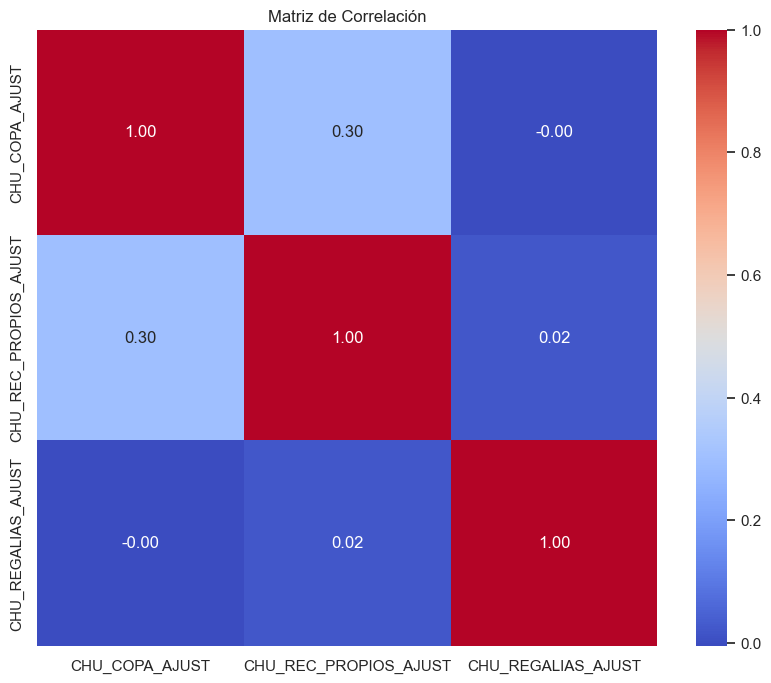

In [50]:

# Calcular la matriz de correlación
correlation_matrix = df_merged.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

# Crear un mapa de calor para visualizar la matriz de correlación

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [46]:
# P-valores menores al nivel de significancia (0.05) implica que la hipotesis nula (X no causa Y) puede rechazarse.
# testgr: Es el tipo de prueba que se utilizará para evaluar la causalidad de Granger. Por defecto, se utiliza 'ssr_chi2test', que es una prueba basada en chi-cuadrado,

def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):


    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# se agrega '_x' al final de los nombres de las columnas para indicar que son las variables "causantes" y '_y' al final de los nombres de las filas para indicar que son las variables "afectadas".

In [57]:
testgr = 'ssr_chi2test'
pd.options.display.float_format = '{:,.20f}'.format
display(grangers_causation_matrix(train_var, variables = train_var.columns, maxlag=20))
pd.options.display.float_format = '{:,.2f}'.format

CHU_COPA_AJUST_x  CHU_REC_PROPIOS_AJUST_x  \
CHU_COPA_AJUST_y        1.00000000000000000000   0.00000000000000000000   
CHU_REC_PROPIOS_AJUST_y 0.00000000000001769292   1.00000000000000000000   
CHU_REGALIAS_AJUST_y    0.00000000000732816775   0.00000003382767412666   

                          CHU_REGALIAS_AJUST_x  
CHU_COPA_AJUST_y        0.00000000127721923844  
CHU_REC_PROPIOS_AJUST_y 0.00000000000000000000  
CHU_REGALIAS_AJUST_y    1.00000000000000000000

Valores de 1.00 en la diagonal: Estos valores indican que no existe causalidad de Granger en las series consigo mismas. Esto es normal, pues no podemos afirmar que una variable se "causa" a sí misma en el sentido de Granger. Así que los valores de la diagonal son siempre 1.00 para indicar esta falta de causalidad.
Valores de 0.00 fuera de la diagonal: Estos valores indican una causalidad de Granger significativa entre las variables. En este contexto, un valor cercano a 0.00 implica que el historial de la variable en la columna (como CHU_REC_PROPIOS_AJUST) ayuda a predecir la variable en la fila (como CHU_COPA_AJUST), y, por lo tanto, existe una causalidad de Granger significativa entre ellas.

#### Resumen de causalidades significativas:
* CHU_COPA_AJUST_y aporta información a CHU_REGALIAS_AJUST_x.
* CHU_REC_PROPIOS_AJUST_y aporta información a CHU_REGALIAS_AJUST_x.
* CHU_REGALIAS_AJUST_y aporta información a CHU_COPA_AJUST_x y CHU_REC_PROPIOS_AJUST_x.

In [58]:
from statsmodels.tsa.api import VAR

model = VAR(train_var)

A continuación se utiliza el método select_order del modelo VAR (model) para seleccionar el orden adecuado del modelo VAR basado en criterios estadísticos. El parámetro maxlags se establece en 70, lo que significa que el código considerará modelos VAR con hasta 70 rezagos.
- AIC (Akaike Information Criterion)  
- BIC (Bayesian Information Criterion)  
- FPE (Final Prediction Error)  
- HQIC (Hannan-Quinn Information Criterion)  

In [84]:
x = model.select_order(maxlags=20)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [108]:
model_fitted = model.fit(16)
model_fitted.summary()

   Summary of Regression Results    
Model:                           VAR
Method:                          OLS
Date:           mié., 30, oct., 2024
Time:                       19:32:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    88.4719
Nobs:                     574.000    HQIC:                   87.7920
Log likelihood:          -27367.9    FPE:                8.69524e+37
AIC:                      87.3572    Det(Omega_mle):     6.80069e+37
--------------------------------------------------------------------
Results for equation CHU_COPA_AJUST
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                       4563093.728789    619988.271496            7.360           0.000
L1.CHU_COPA_AJUST                 0.428007         0.043645            9.807          

Correlation matrix of residuals
                         CHU_COPA_AJUST  CHU_REC_PROPIOS_AJUST  CHU_REGALIAS_AJUST
CHU_COPA_AJUST                 1.000000               0.087812           -0.024886
CHU_REC_PROPIOS_AJUST          0.087812               1.000000            0.103562
CHU_REGALIAS_AJUST            -0.024886               0.103562            1.000000

Predicción

In [116]:
# Funcion que recibe listas con las predicciones e intervalos de confianza de las 3 series y devuelve un
# dataframe para la serie indicada por la variable indice
def serializar(predicciones_, test_, indice, futuro_, intervalos=True):

    serie = {
        "FECHA": test_.index[:futuro_],
        "serie"+str(indice): predicciones_[0][:,indice-1].tolist(),
        "serie"+str(indice)+"_inf": predicciones_[1][:,indice-1].tolist(),
        "serie"+str(indice)+"_sup": predicciones_[2][:,indice-1].tolist()}
    serie = pd.DataFrame(serie, columns=["FECHA", "serie"+str(indice),
                                         "serie"+str(indice)+"_inf", "serie"+str(indice)+"_sup"])
    serie.set_index("FECHA", inplace=True)
    if (intervalos==False):
        serie.loc[serie["serie"+str(indice)+"_inf"] < 0, "serie"+str(indice)+"_inf"] = 0
        serie.loc[serie["serie"+str(indice)+"_sup"] < 0, "serie"+str(indice)+"_sup"] = 0
    return serie

In [87]:


def serializar(predicciones_, test_, indice, futuro_, intervalos=True):
    # Verificar si predicciones_ tiene la longitud esperada
    predicciones = predicciones_[0]  # Predicciones
    inf_intervalo = predicciones_[1]  # Intervalos inferiores
    sup_intervalo = predicciones_[2]  # Intervalos superiores

    # Asegúrate de que los arrays tienen la longitud correcta
    print("Longitud de predicciones:", predicciones.shape[0])
    print("Longitud de inf_intervalo:", inf_intervalo.shape[0])
    print("Longitud de sup_intervalo:", sup_intervalo.shape[0])
    
    # Asegúrate de que las longitudes coincidan con el número de pasos de predicción
    if len(test_.index[:futuro_]) != predicciones.shape[0]:
        raise ValueError("La longitud de las predicciones no coincide con el número de pasos a predecir.")

    # Crear un diccionario para la nueva serie
    serie = {
        "FECHA": test_.index[:futuro_],  # Asegúrate de que esto coincida con el tamaño de predicciones
        "serie" + str(indice): predicciones[:, indice - 1].tolist(),
        "serie" + str(indice) + "_inf": inf_intervalo[:, indice - 1].tolist(),
        "serie" + str(indice) + "_sup": sup_intervalo[:, indice - 1].tolist()
    }

    # Convertir el diccionario en un DataFrame
    serie = pd.DataFrame(serie, columns=["FECHA", "serie" + str(indice),
                                         "serie" + str(indice) + "_inf", "serie" + str(indice) + "_sup"])
    
    # Establecer FECHA como índice
    serie.set_index("FECHA", inplace=True)
    
    # Ajustar valores de intervalos a 0 si son negativos, si es necesario
    if not intervalos:
        serie.loc[serie["serie" + str(indice) + "_inf"] < 0, "serie" + str(indice) + "_inf"] = 0
        serie.loc[serie["serie" + str(indice) + "_sup"] < 0, "serie" + str(indice) + "_sup"] = 0
        
    return serie


In [95]:
def graficar_pred(serie_test, serie_pred, titulo="Valores Originales vs Predicciones",
                  xlabel="Fecha", ylabel="Valor", intervalos=True):
    # serie_test:
    # serie_pred:

    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.iloc[:,0].plot(label="Predicciones")
    if (intervalos==True):
        plt.fill_between(serie_test.index, serie_pred.iloc[:,1], serie_pred.iloc[:,2], color='green', alpha=0.2)
        # serie_pred.iloc[:,2].plot(label="Intervalo de Confianza Superior")
        # serie_pred.iloc[:,1].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.5', dashes=(5,2,1,2))

Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15
Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15
Longitud de predicciones: 15
Longitud de inf_intervalo: 15
Longitud de sup_intervalo: 15


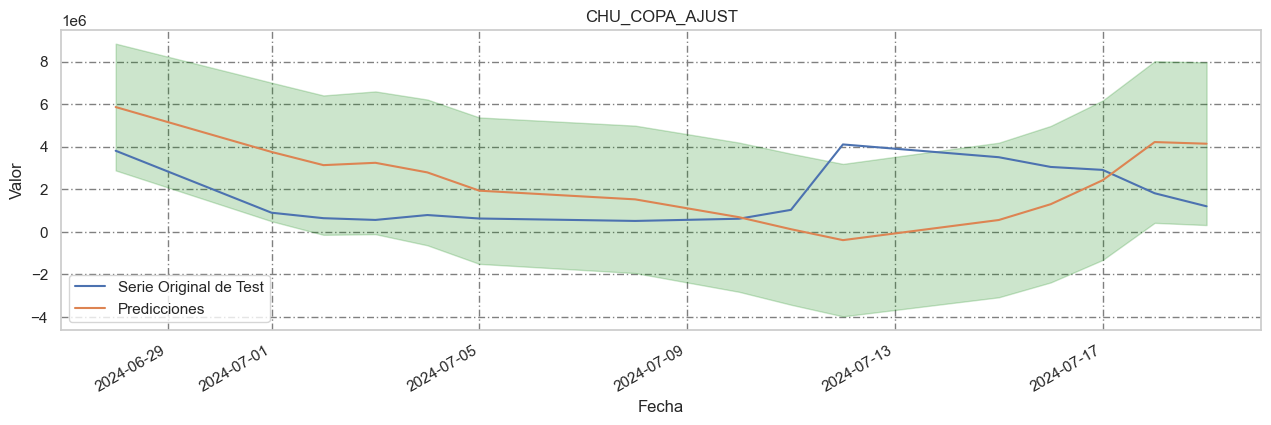

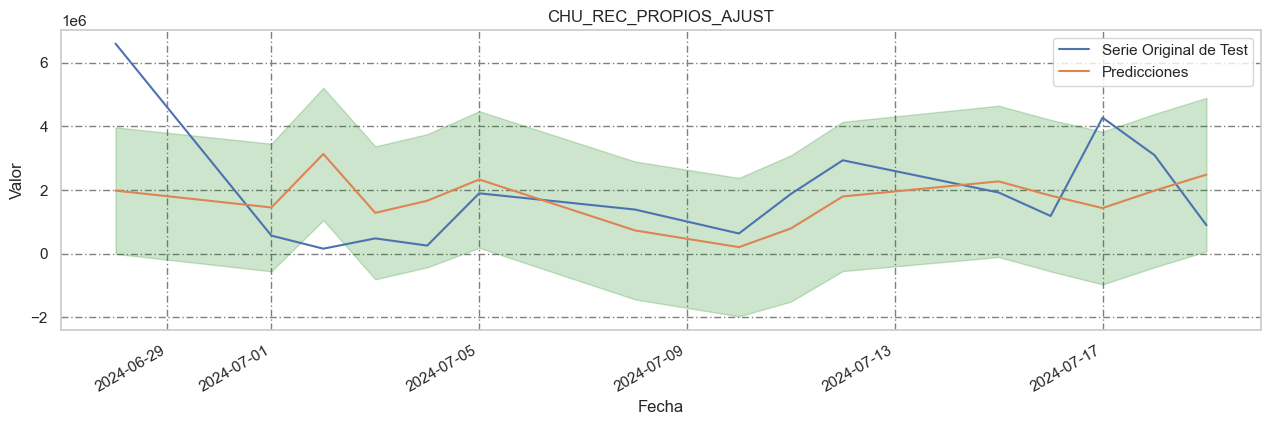

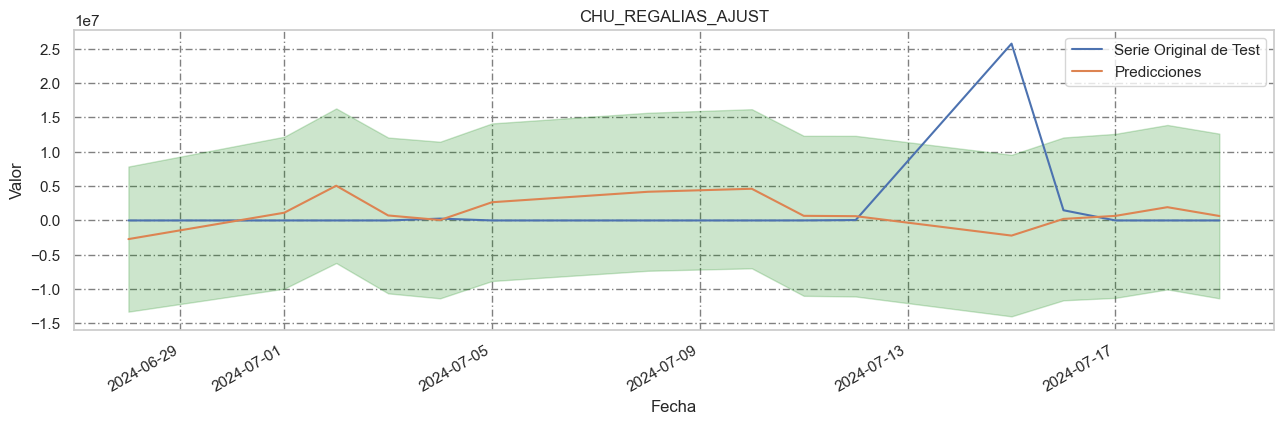

In [96]:
# Con la variable futuro se indican cuantas unidades en tiempo
# hacia adelante se quieren predecir
futuro = 15
lag_orden = 16

predicciones = model_fitted.forecast_interval(train_var.values[-lag_orden:], steps=futuro)

df = list()
for i in range(1, 4):  # Cambié de [1, 2, 3] a range(1, 4) para mayor claridad
    df.append(serializar(predicciones, test_var, i, futuro))

serieVAR = ['CHU_COPA_AJUST', 'CHU_REC_PROPIOS_AJUST', 'CHU_REGALIAS_AJUST']

for i, serie in enumerate(serieVAR):
    graficar_pred(test_var[serie][:futuro], df[i], titulo=serie)


In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import jarque_bera, shapiro, boxcox, probplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey

In [110]:
def test_residuos(residuos):


    # Test de Jarque Bera
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    jarquebera = jarque_bera(residuos)
    print('Jarque-Bera')
    print(f'p-valor: {jarquebera[1]}\n')

    # Test de Shapiro Wilks
    # H0: los datos estan distribuidos normalmente
    # Ha: los datos no estan distribuidos normalmente
    # Si p < 0.05 se rechaza la hipotesis nula
    shapir = shapiro(residuos)
    print('Shapiro')
    print(f'p-valor: {shapir[1]}\n')

In [111]:
def evaluar_residuos(residuos):
    residuos.plot(title='Residuos', figsize=(12, 3))
    plt.axhline(0, linestyle='--', color='k')
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    ax[0].set_title('Residuos KDE')
    ax[1].set_title('Q-Q Plot')
    residuos.plot(kind='kde', ax=ax[0])
    probplot(residuos, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(residuos)
    acf.set_size_inches(12,3)
    plt.show()
    print('Descriptivo Residuos\n')
    print(f'{residuos.describe()}\n\n')
    print('Test sobre los Residuos\n')
    test_residuos(residuos)

CHU_COPA_AJUST
-----------------------------
MSE: 5349262977169.936
MAE: 2030742.0270007958
RMSE: 2312847.3743785894
MAPE: 1.7808
MAPE_MEAN: 1.0491
Evaluacion de residuos de Serie 


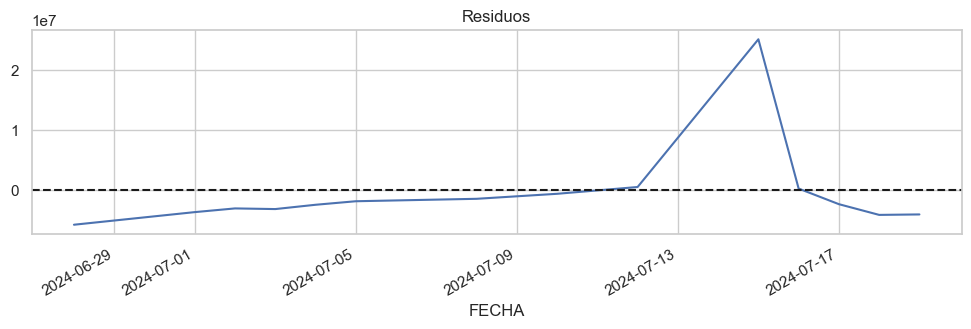

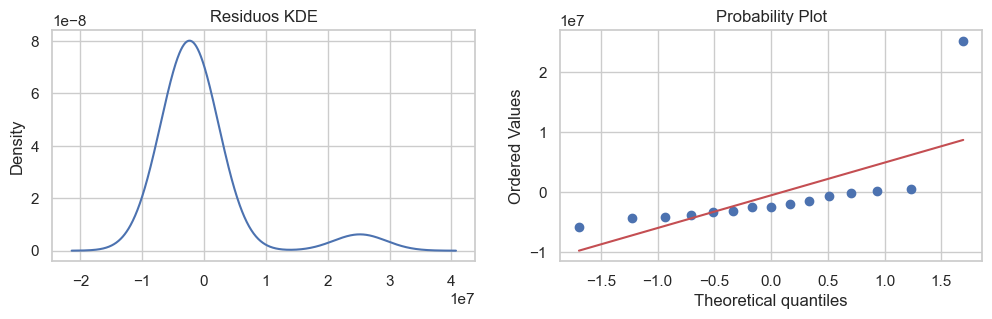

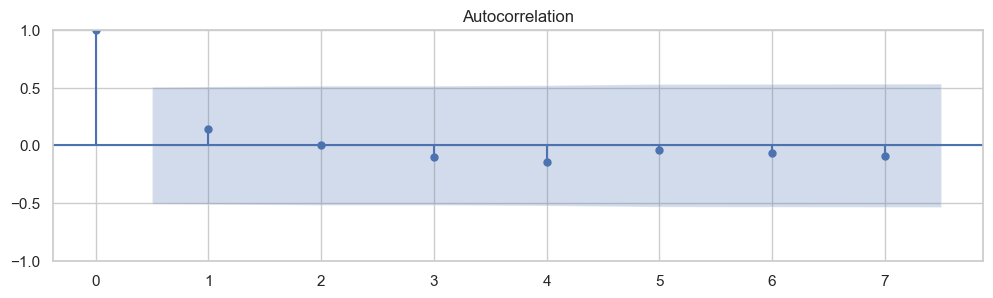

Descriptivo Residuos

count           15.00
mean      -511,182.84
std      7,340,348.78
min     -5,864,050.21
25%     -3,496,110.75
50%     -2,420,702.38
75%       -396,888.04
max     25,211,282.59
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 5.4572028348553445e-16

Shapiro
p-valor: 5.226361564065046e-06



In [112]:
print("CHU_COPA_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_COPA_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

CHU_REC_PROPIOS_AJUST
-----------------------------
MSE: 4332401447586.9
MAE: 1681551.9516500393
RMSE: 2081442.1557148544
MAPE: 3.2626
MAPE_MEAN: 1.9463
Evaluacion de residuos de Serie 


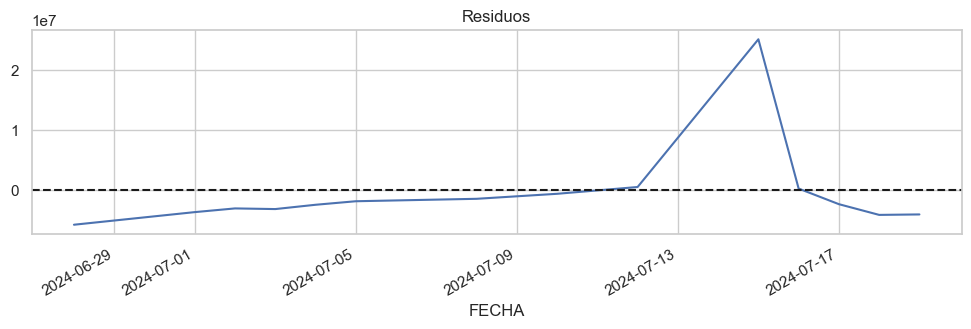

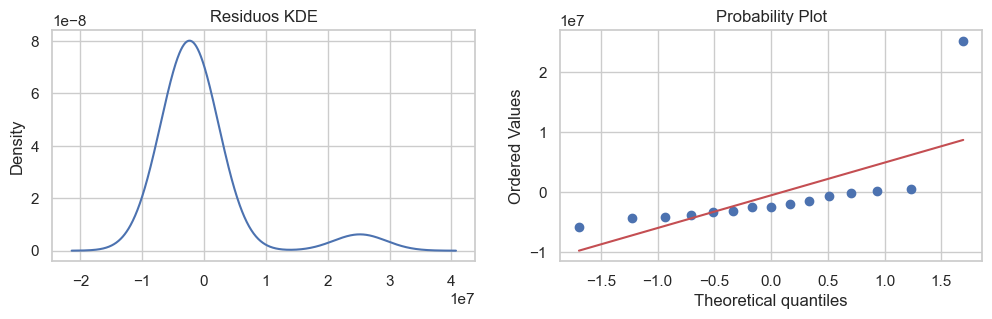

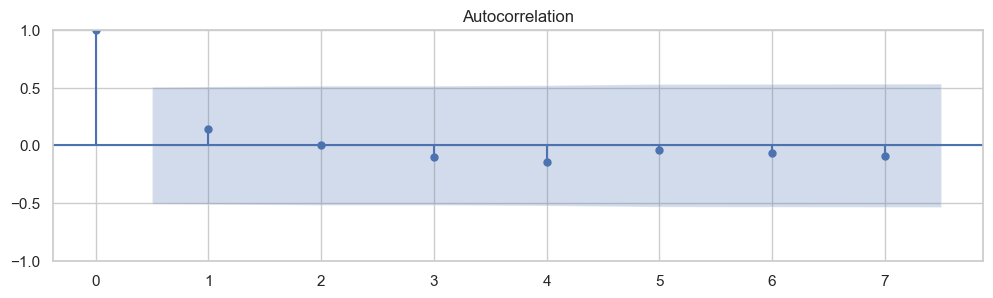

Descriptivo Residuos

count           15.00
mean      -511,182.84
std      7,340,348.78
min     -5,864,050.21
25%     -3,496,110.75
50%     -2,420,702.38
75%       -396,888.04
max     25,211,282.59
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 5.4572028348553445e-16

Shapiro
p-valor: 5.226361564065046e-06



In [113]:
print("CHU_REC_PROPIOS_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_REC_PROPIOS_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

CHU_REGALIAS_AJUST
-----------------------------
MSE: 50549980135267.39
MAE: 3959110.2391116098
RMSE: 7109850.922154936
MAPE: 9.2755781092173e+21
MAPE_MEAN: 5.519477596116376e+21
Evaluacion de residuos de Serie 


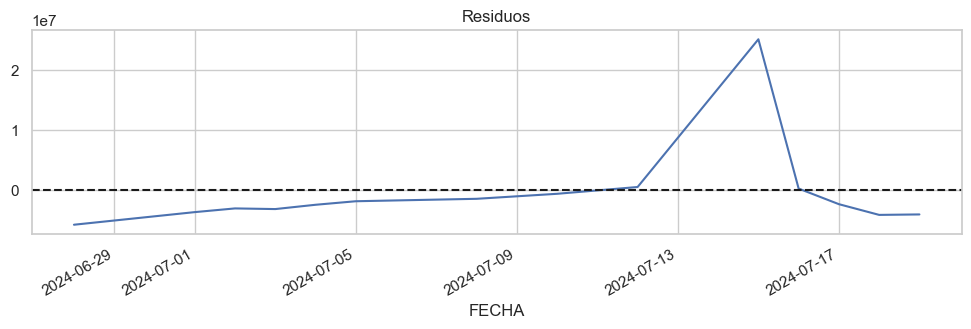

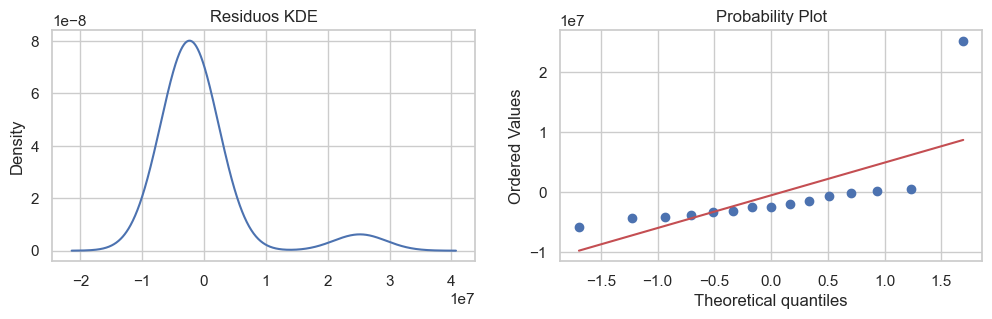

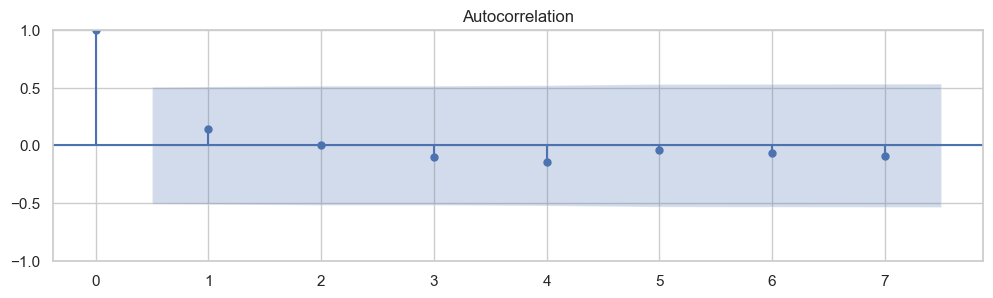

Descriptivo Residuos

count           15.00
mean      -511,182.84
std      7,340,348.78
min     -5,864,050.21
25%     -3,496,110.75
50%     -2,420,702.38
75%       -396,888.04
max     25,211,282.59
dtype: float64


Test sobre los Residuos

Jarque-Bera
p-valor: 5.4572028348553445e-16

Shapiro
p-valor: 5.226361564065046e-06



In [114]:
print("CHU_REGALIAS_AJUST")
print("-----------------------------")
evaluar_metricas(test_var.CHU_REGALIAS_AJUST[:futuro], df[0].iloc[:,0])
print(f"Evaluacion de residuos de Serie ")
evaluar_residuos(test_var[serie][:futuro]-df[0].iloc[:,0])

## Ejercicio 11
Analizar la función impulso respuesta y realizar distintas pruebas para analizar la causalidad.

Justificar la elección del modelo con todo lo visto en clase. Es posible complementar con otros análisis

*Debemos ver cómo las variables en el modelo responden a un shock o perturbación en una de las variables.*

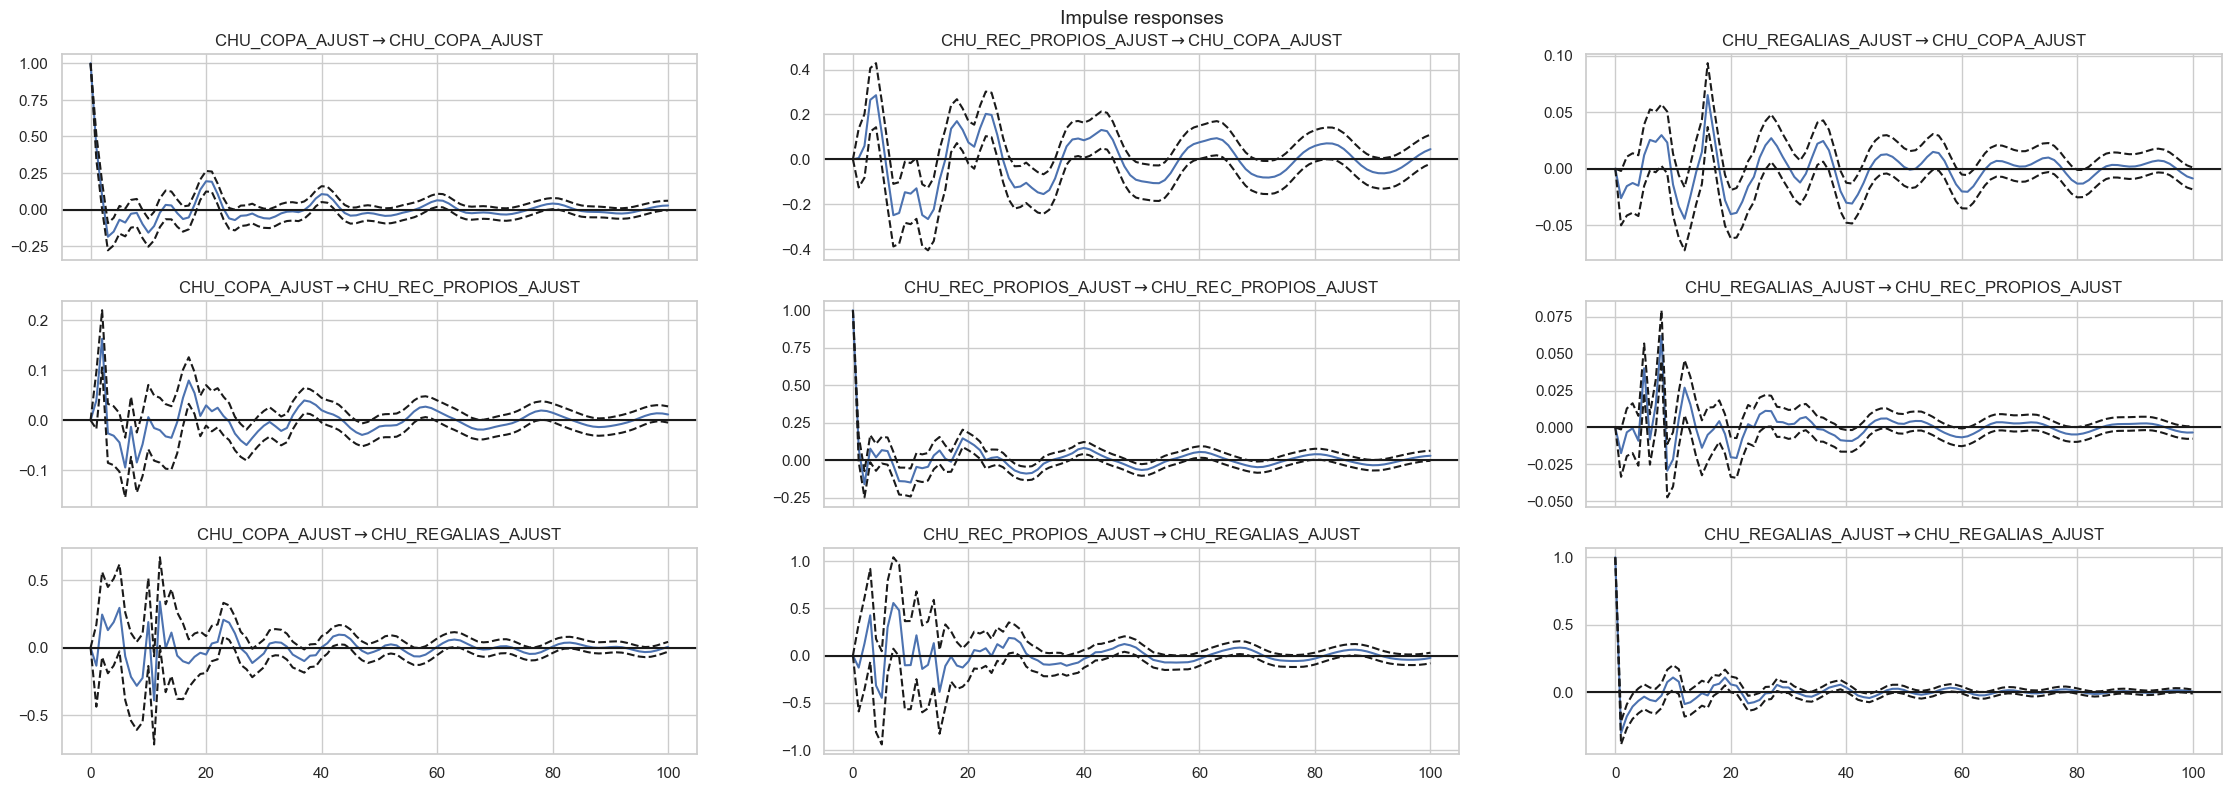

In [124]:
# Impulse response function for the model we trained
irf = model_fitted.irf(periods=100)
irf.plot(figsize=(24,8)) #Impulse response function plot
plt.show()

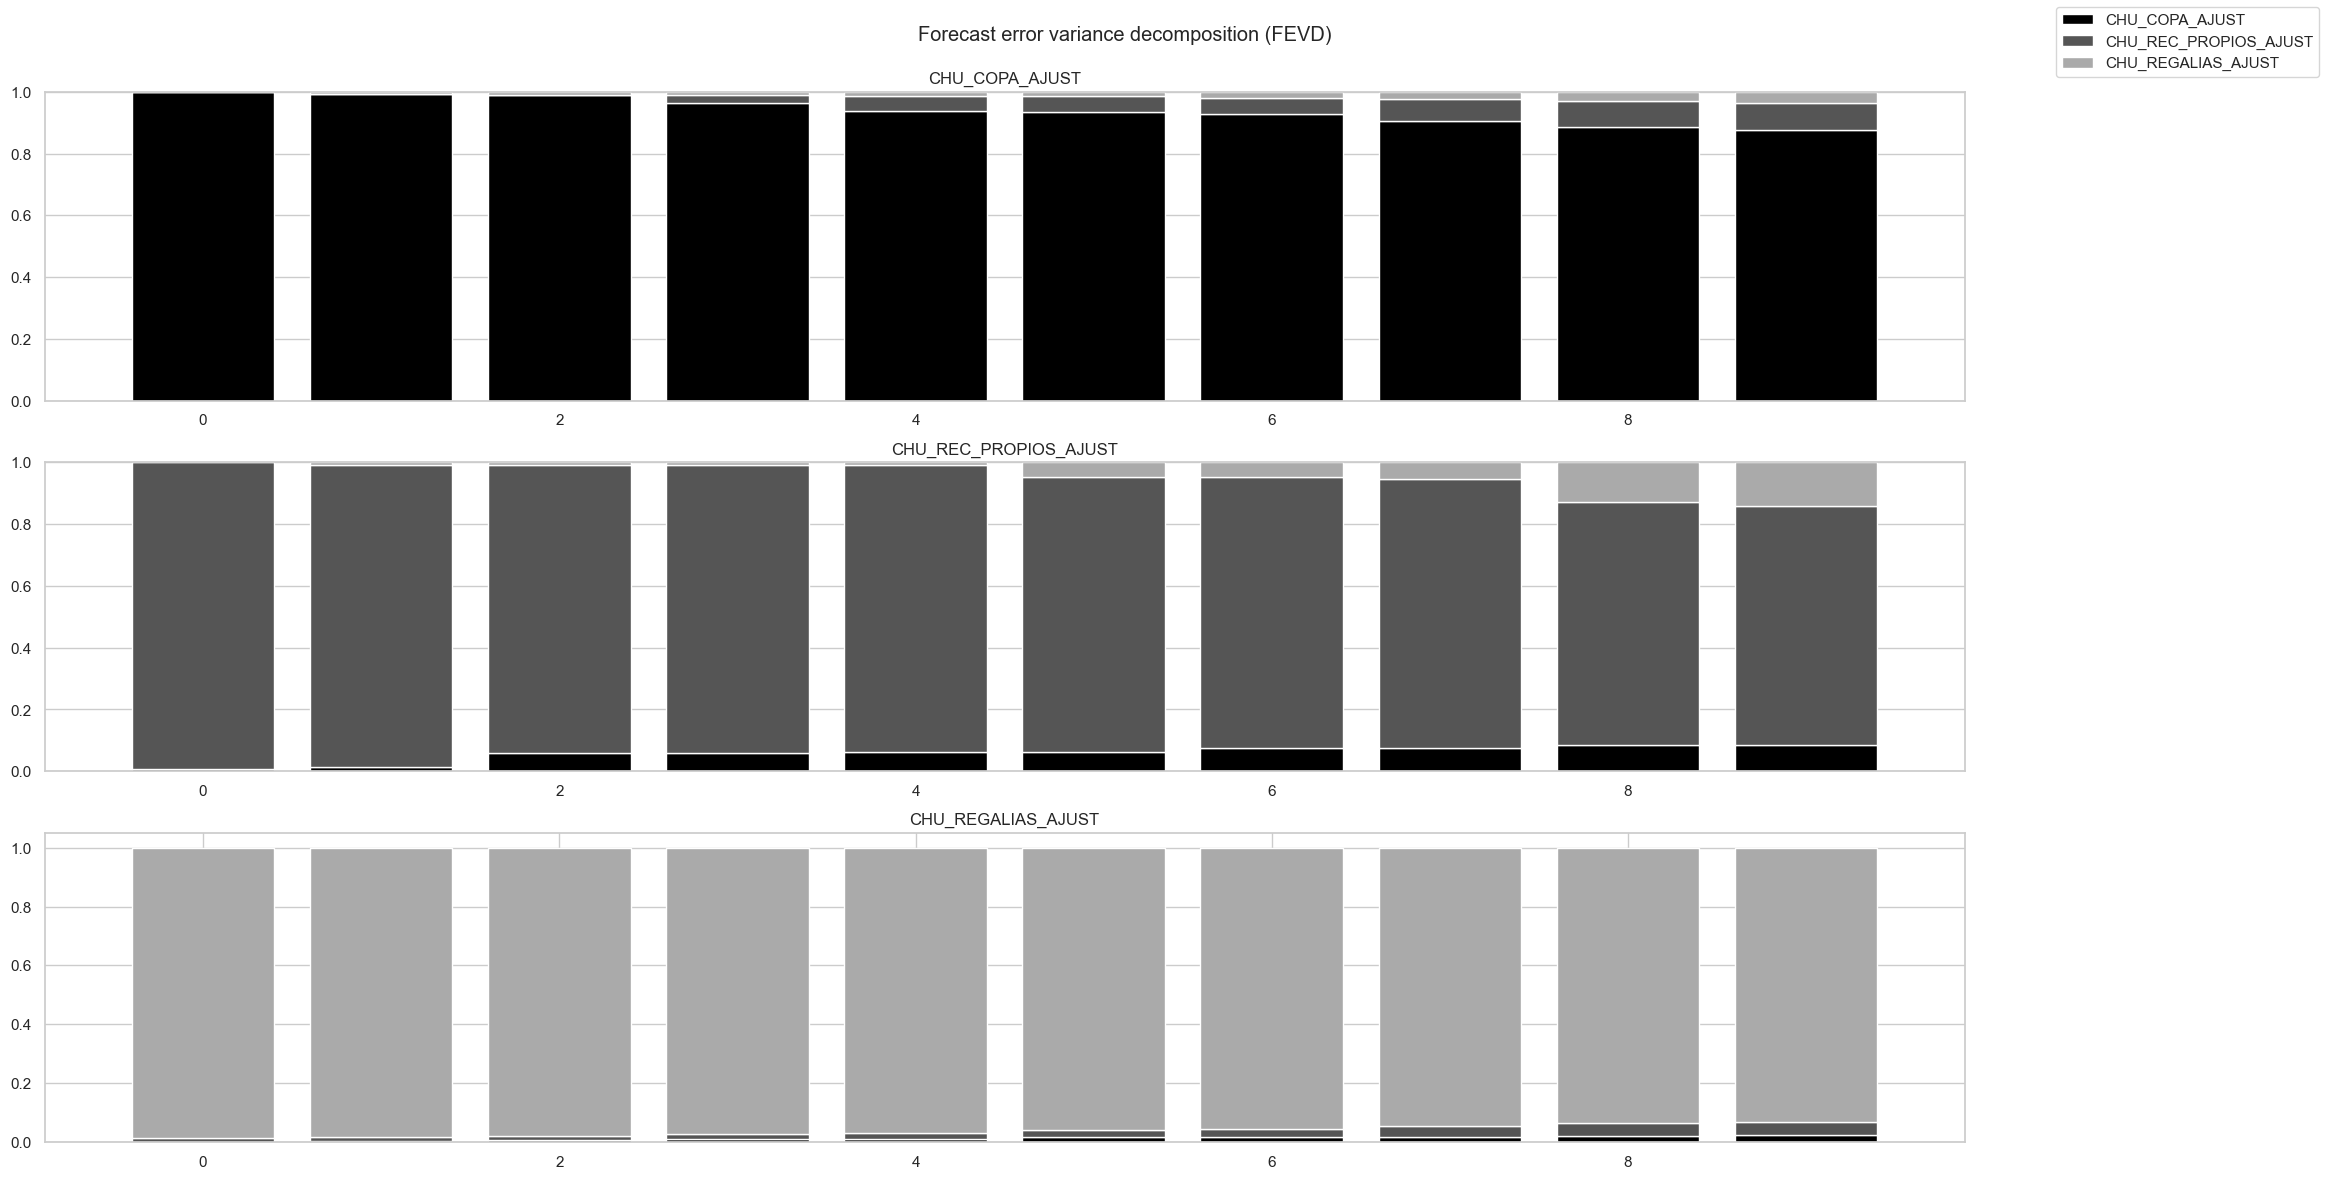

In [126]:
fevd = model_fitted.fevd(10)
fevd.plot(figsize=(24,12))
plt.show()

In [127]:
fevd.summary()

FEVD for CHU_COPA_AJUST
     CHU_COPA_AJUST  CHU_REC_PROPIOS_AJUST  CHU_REGALIAS_AJUST
0          1.000000               0.000000            0.000000
1          0.992862               0.000031            0.007108
2          0.989522               0.000983            0.009495
3          0.965292               0.024070            0.010638
4          0.938916               0.048740            0.012345
5          0.933254               0.053194            0.013551
6          0.927117               0.053574            0.019309
7          0.906170               0.069958            0.023872
8          0.885385               0.083632            0.030983
9          0.877440               0.087557            0.035004

FEVD for CHU_REC_PROPIOS_AJUST
     CHU_COPA_AJUST  CHU_REC_PROPIOS_AJUST  CHU_REGALIAS_AJUST
0          0.007711               0.992289            0.000000
1          0.012152               0.979560            0.008288
2          0.059623               0.932423            0.007954

Interpretacion: Observando por ejemplo el período 5, Dado un impulso en la variable CHU_COPA_AJUST, el 93% esta explicado por ella misma, el 5% Por CHU_REC_PROPIOS_AJUST y un 2% Por CHU_REGALIAS_AJUST.

## Ejercicio 12

En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior.

(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.


In [144]:

df_total = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_total.set_index("FECHA", inplace=True)
df_total["MES"] = df_total.index.strftime("%m-%Y")

df_mes = df_total.groupby("MES").sum()

df_mes = df_mes[["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]]
df_mes["FECHA"] = "01-" + df_mes.index
df_mes["FECHA"] = pd.to_datetime(df_mes["FECHA"], format="%d-%m-%Y")

df_mes.set_index("FECHA", inplace=True,drop=True)
df_mes.sort_index(inplace=True)
for col in ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]:
    df_mes.loc[df_mes[col]<=0,col] = None
    
df_mes = [df_mes["CHU_COPA_AJUST"].dropna(), df_mes["CHU_REC_PROPIOS_AJUST"].dropna(),df_mes["CHU_REGALIAS_AJUST"].fillna(0)]


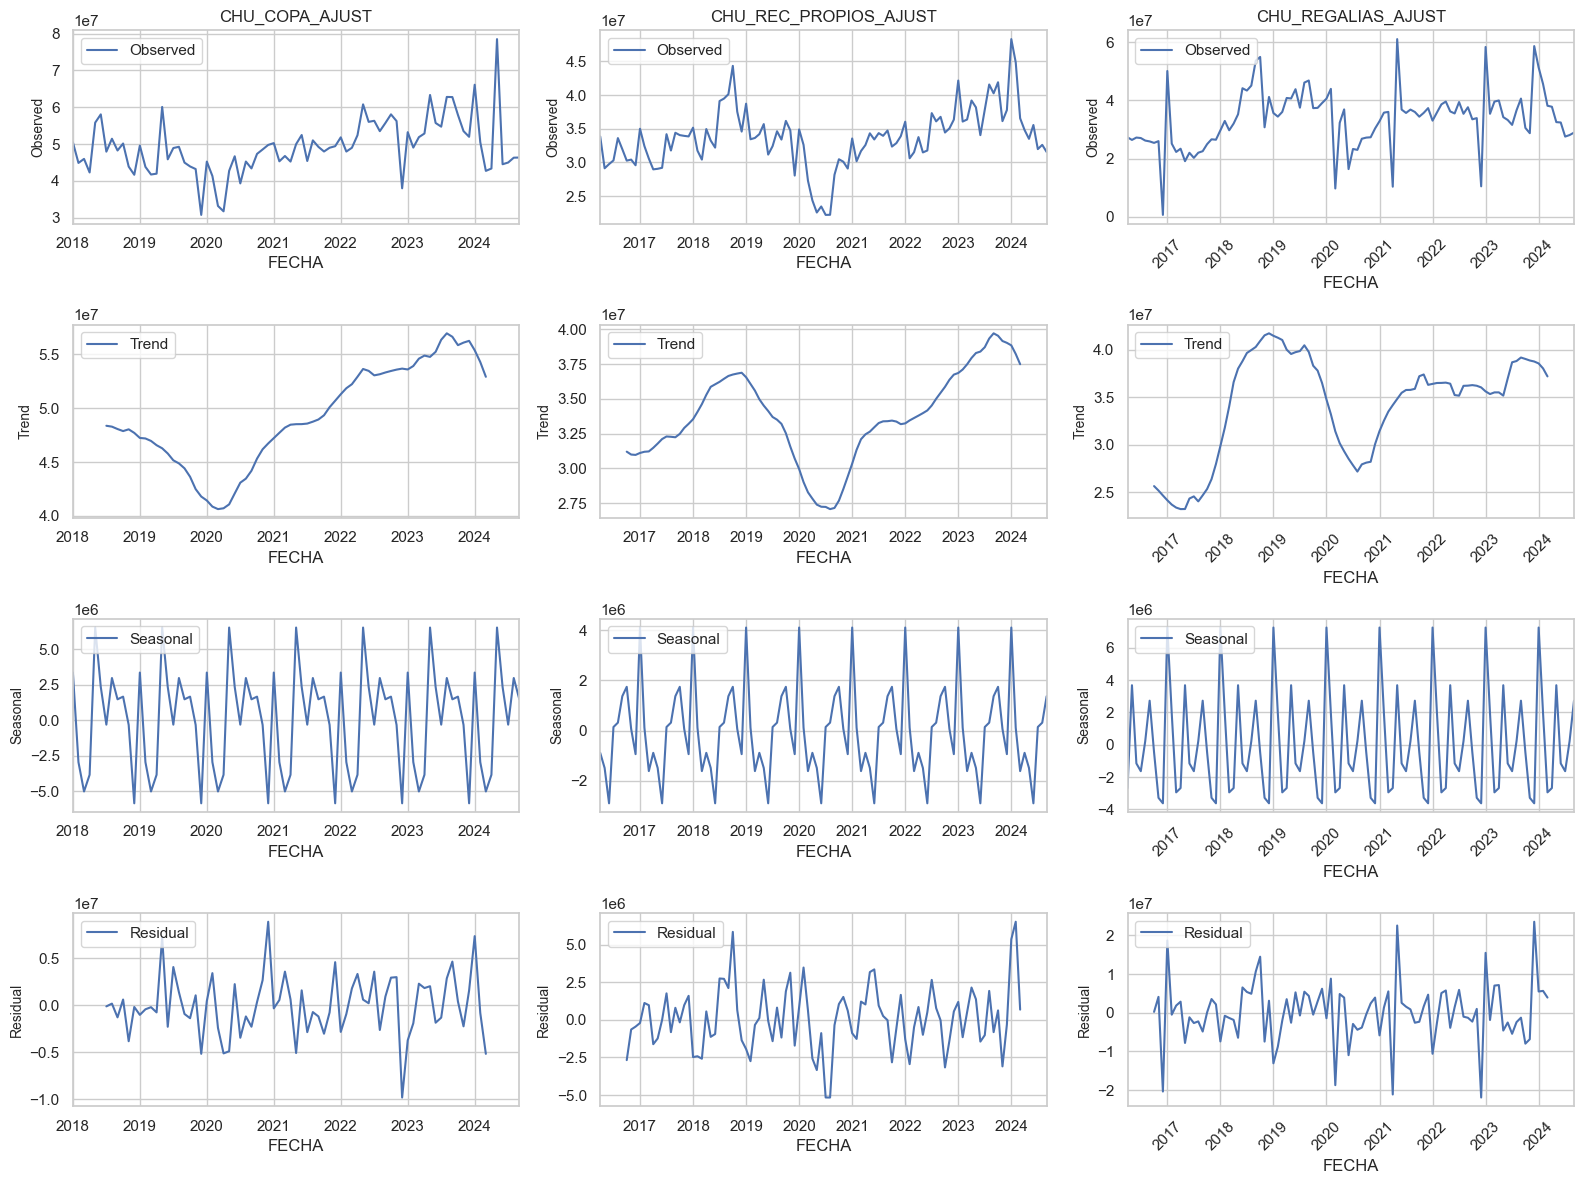

In [145]:
periodos = [12,12,12]
display(HTML("<h2>Descomposición de las series Mensuales</h2>"))
funciones.componentes(df_mes, periodos, titulos)

In [186]:

for i, df_train in enumerate(df_mes):
    # Entrenamiento del modelo ARIMA
       
    model = auto_arima(df_train,
                    start_p=0,
                    start_q=0,
                    max_p=8,
                    max_q=8,
                    m=12, # segun gpt recomiendas m=21 ya que 21 dias laborales en un mes.
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=False,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)
    titulo = f"sarima_mensual_df{i}"
    save_model({
        "modelo": model,
        "dataset": f"{df_train.name} mensual",
        "titulo": titulo,
        "aic": model.aic(),
        "order": model.order,
        "seasonal_order": model.seasonal_order})

    
display(HTML("<h2>Modelos SARIMA Mensual</h2>"))
display(pd.DataFrame(models).tail(3))
 

modelo                        dataset  \
9    ARIMA(0,0,2)(2,0,2)[12] intercept         CHU_COPA_AJUST mensual   
10   ARIMA(0,0,2)(0,0,1)[12] intercept  CHU_REC_PROPIOS_AJUST mensual   
11   ARIMA(0,0,0)(0,0,0)[12] intercept     CHU_REGALIAS_AJUST mensual   

                titulo      aic      order seasonal_order  
9   sarima_mensual_df0 3,707.10  (0, 0, 2)  (2, 0, 2, 12)  
10  sarima_mensual_df1 3,411.55  (0, 0, 2)  (0, 0, 1, 12)  
11  sarima_mensual_df2 3,582.99  (0, 0, 0)  (0, 0, 0, 12)

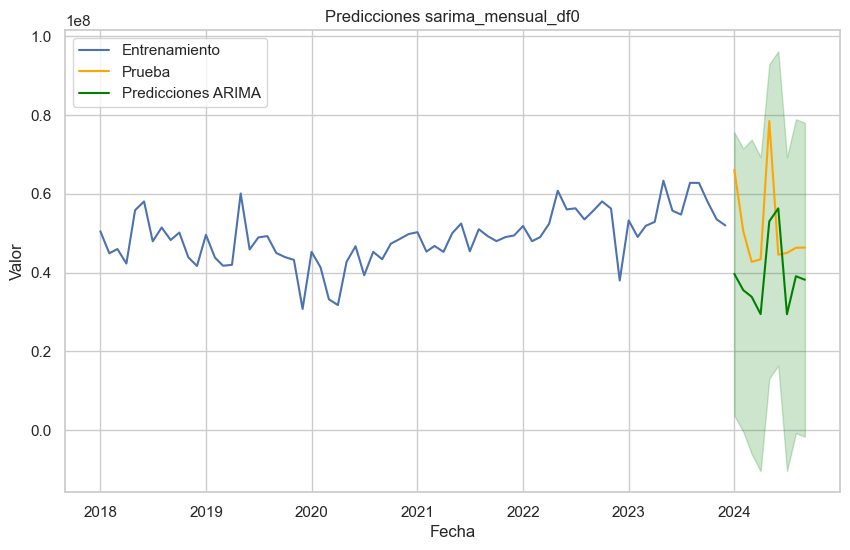

In [191]:
modelos = pd.DataFrame(models)
modelo_copa_mensual= modelos[modelos["titulo"]=="sarima_mensual_df0"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
train = df_mes[0].iloc[:int(len(df_mes[0])*0.9)]
test = df_mes[0][int(len(df_mes[0])*0.9):]
forecast_copa_mensual, conf_int  = modelo_copa_mensual.predict(n_periods=len(test),return_conf_int=True)


# Crear un índice de fechas para el pronóstico
forecast_copa_mensual_df = pd.DataFrame(forecast_copa_mensual,columns=["CHU_COPA_AJUST"])
forecast_copa_mensual_df.index = test.index

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(forecast_copa_mensual_df.index, forecast_copa_mensual_df["CHU_COPA_AJUST"], label='Predicciones ARIMA', color='green')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones sarima_mensual_df0')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

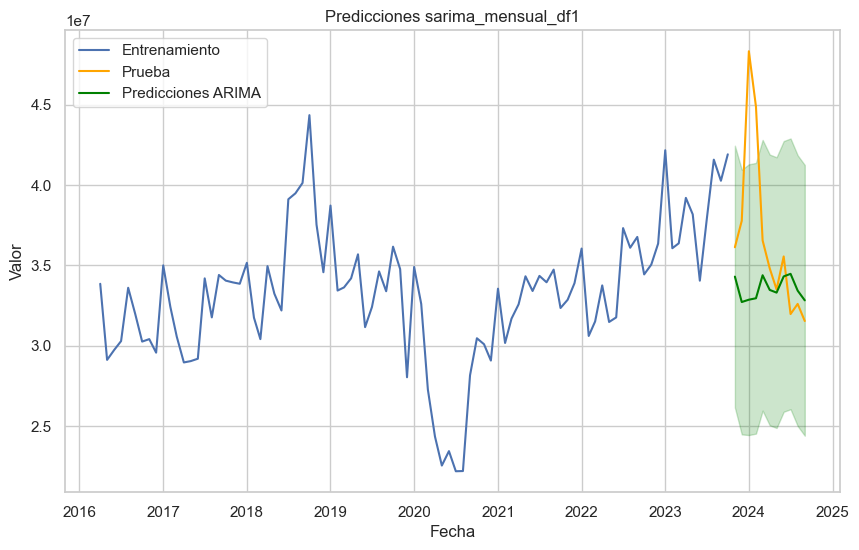

In [189]:
modelos = pd.DataFrame(models)
modelo_recp_mensual= modelos[modelos["titulo"]=="sarima_mensual_df1"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
train = df_mes[1].iloc[:int(len(df_mes[1])*0.9)]
test = df_mes[1][int(len(df_mes[1])*0.9):]
forecast_recp_mensual, conf_int  = modelo_recp_mensual.predict(n_periods=len(test),return_conf_int=True)


# Crear un índice de fechas para el pronóstico
forecast_recp_mensual_df = pd.DataFrame(forecast_recp_mensual,columns=["CHU_REC_PROPIOS_AJUST"])
forecast_recp_mensual_df.index = test.index

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(forecast_recp_mensual_df.index, forecast_recp_mensual_df["CHU_REC_PROPIOS_AJUST"], label='Predicciones ARIMA', color='green')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones sarima_mensual_df1')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

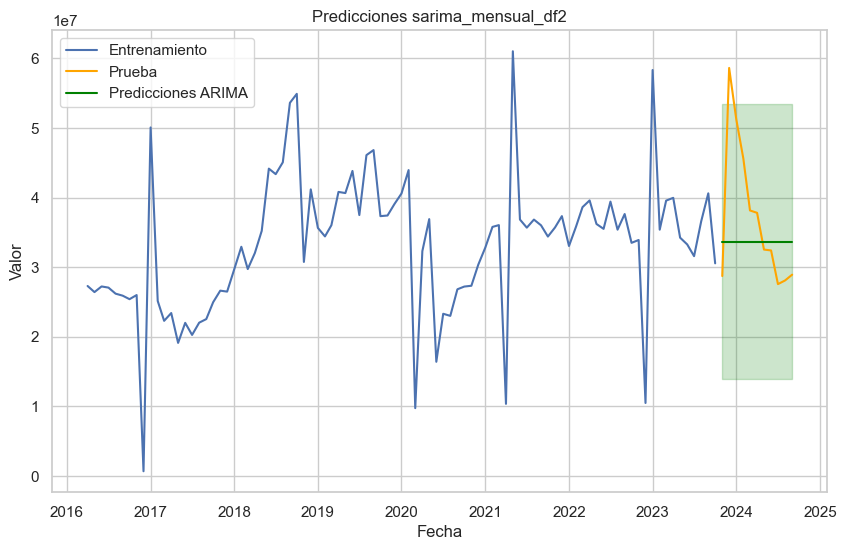

In [190]:
modelos = pd.DataFrame(models)
modelo_regal_mensual= modelos[modelos["titulo"]=="sarima_mensual_df2"]["modelo"].values[0]
# Realizar el pronóstico
n_steps = 12
train = df_mes[2].iloc[:int(len(df_mes[2])*0.9)]
test = df_mes[2][int(len(df_mes[2])*0.9):]
forecast_regal_mensual, conf_int  = modelo_regal_mensual.predict(n_periods=len(test),return_conf_int=True)


# Crear un índice de fechas para el pronóstico
forecast_regal_mensual_df = pd.DataFrame(forecast_regal_mensual,columns=["CHU_REGALIAS_AJUST"])
forecast_regal_mensual_df.index = test.index

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Prueba', color='orange')
plt.plot(forecast_regal_mensual_df.index, forecast_regal_mensual_df["CHU_REGALIAS_AJUST"], label='Predicciones ARIMA', color='green')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.2)
plt.title(f'Predicciones sarima_mensual_df2')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [205]:
for modelo in models[-3:]:
    test_de_box_pierce(modelo["modelo"],modelo["titulo"],modelo["aic"])

resultados_boxp = pd.DataFrame(resultados_boxp)
display(HTML("<h2>Test de Box-Pierce</h2>"))
display(resultados_boxp)

titulo     Q  p_value  autocorrelación      aic
0  sarima_mensual_df0 50.52     0.00             True 3,707.10
1  sarima_mensual_df1 38.63     0.00             True 3,411.55
2  sarima_mensual_df2 18.10     0.05            False 3,582.99

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9292b23b-d668-48da-87b9-72d6854ea93f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>